# Final Project
---
## Itamar Mishani - 311337604

In [1]:
from sympy import *
from matplotlib import pyplot as plt 
from mpl_toolkits import mplot3d
from scipy.integrate import odeint
from IPython.display import Image
import numpy as np
import pandas as pd 
import networkx as nx
import seaborn as sns
import math
import random

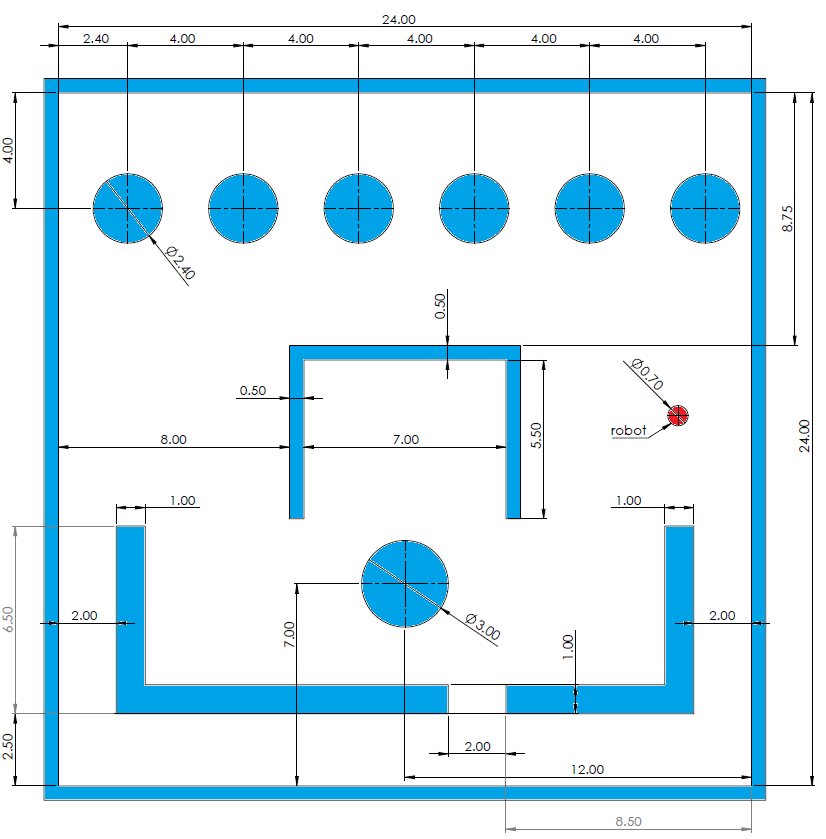

In [2]:
Image("ques_1_png.png")

## mobile robot path planning

In [3]:
x_s = [1.01, 1.2]
x_g = [7.9, 8.3]

### pseudo code

<i> Generate RRT  <i/>
$ \tau _{init}(x_{init}) $ <br>
from 1 to k:  
- create random state: $ x_{rand} $ 
- find nearest neighbor $ x_{near}$
- select input  $ u $ 
- find new state $ x_{new} $
- add new vertex to $ \tau $ <- $ x_{new}$
- add new edge to $ \tau $  $ x_{new} $ <- $ x_{near}$
- return $ \tau$
    
    
<i> Generate RRT*  <i/>
$ \tau _{init}(x_{init}) $ <br>
from 1 to k:  
- create random state: $ x_{rand} $ 
- find nearest neighbor $ x_{near}$
- select input  $ u $ 
- find new state $ x_{new} $
- calculate cost of $ x_{new} $
- find neighbors
- choose parent
- rewire
- add new vertex to $ \tau $ <- $ x_{new}$
- add new edge to $ \tau $ 
- return $ \tau$


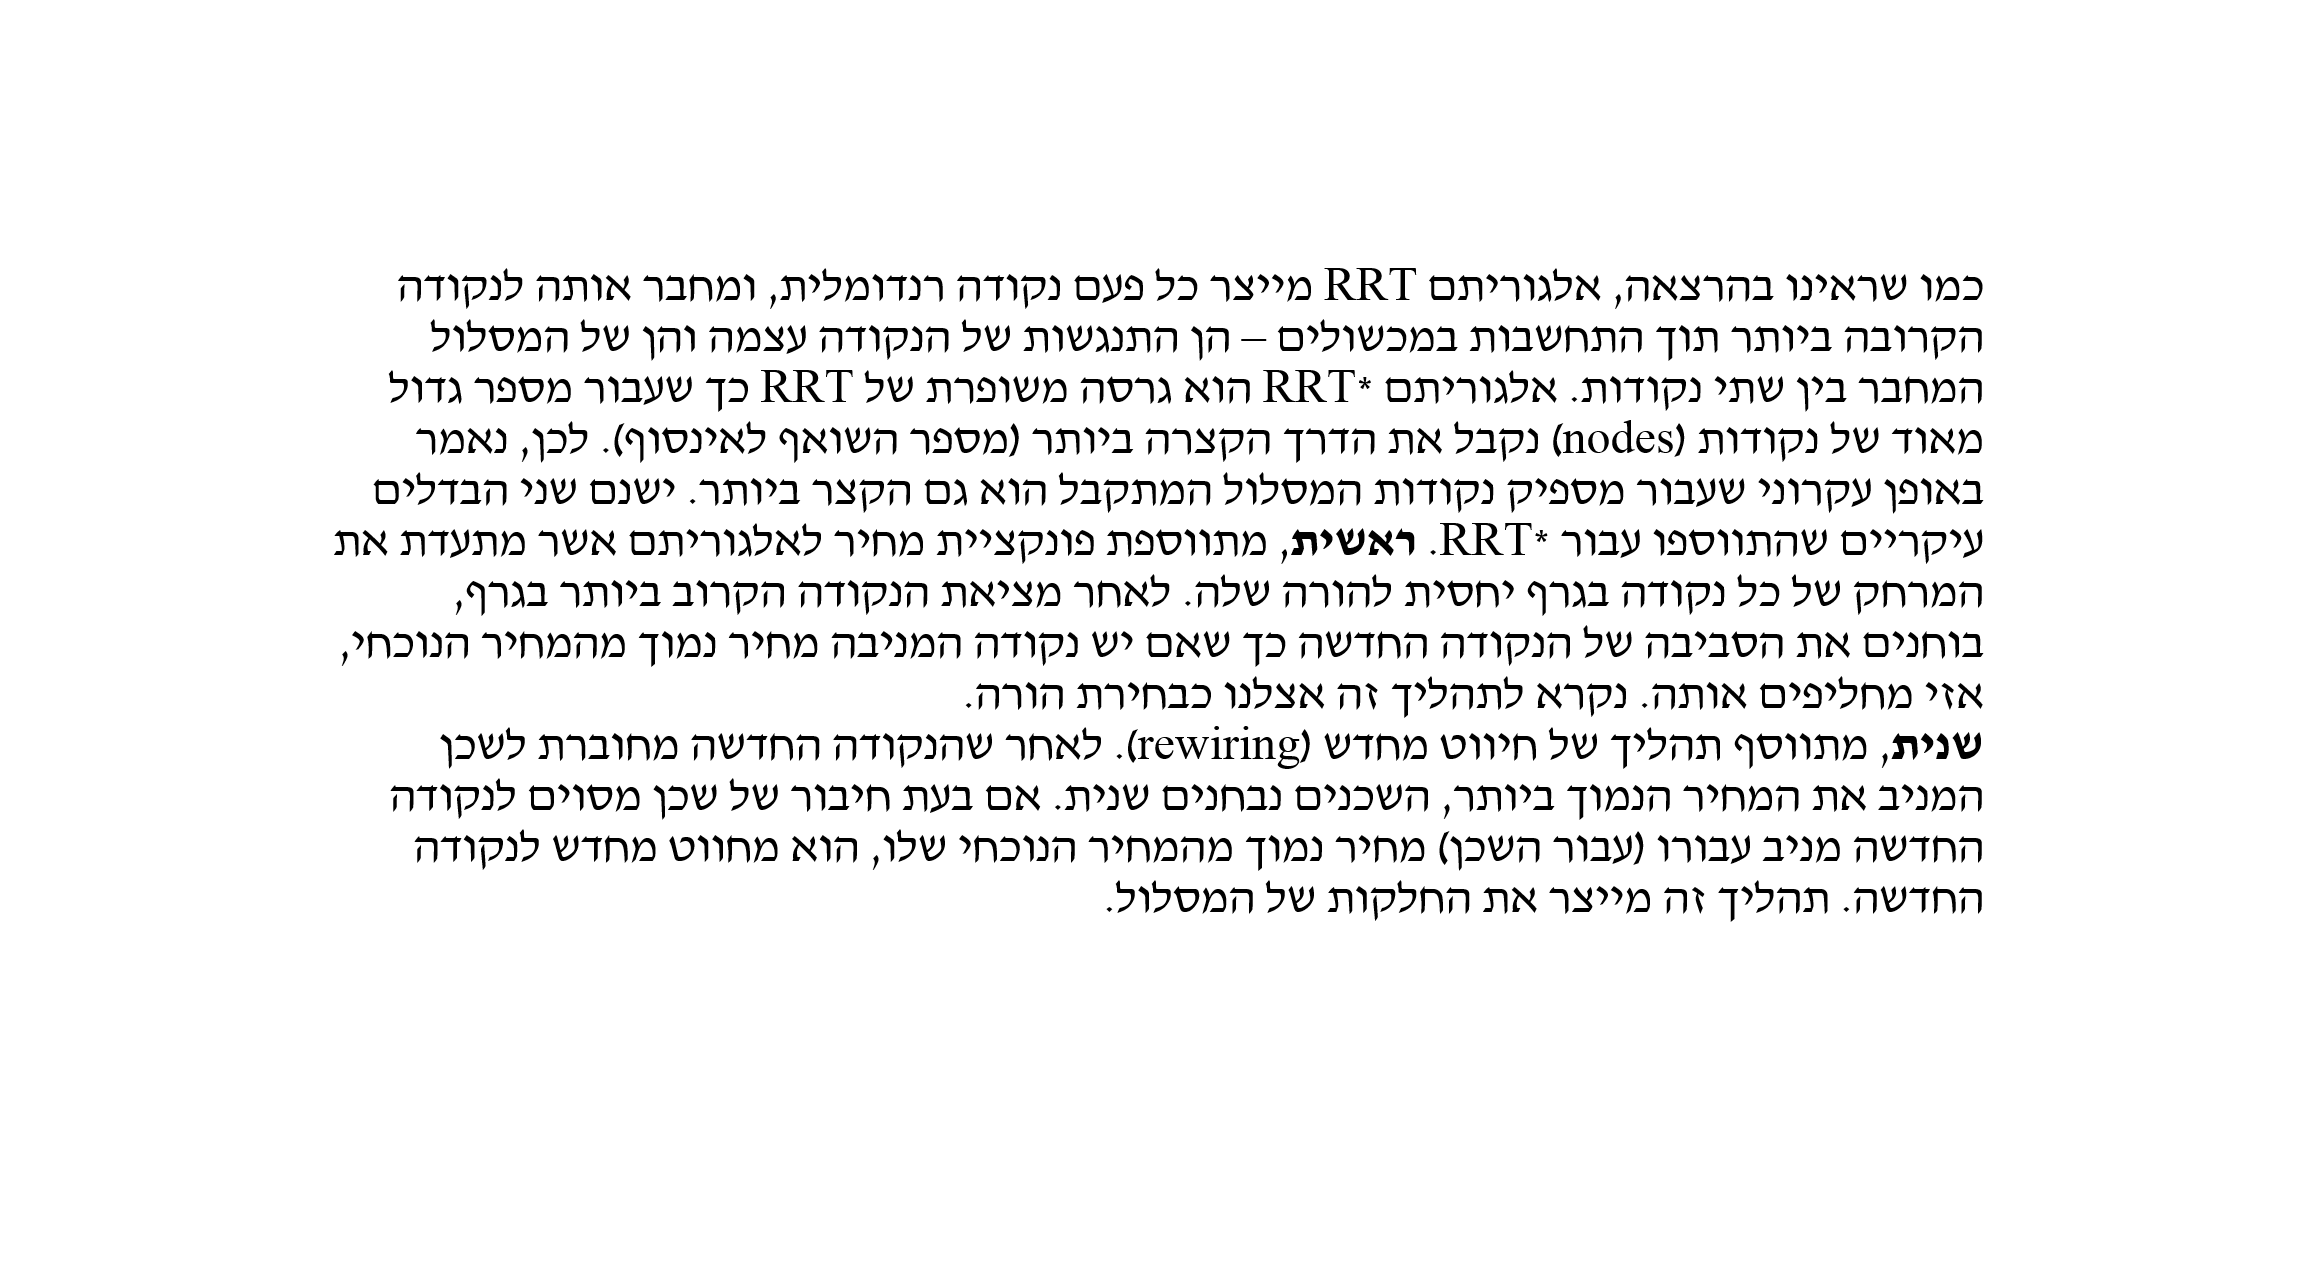

In [4]:
Image("RRT_star.png")

In [5]:
class RRT_star:
    
    def __init__(self, start, goal, obstacles,rand_area, robot_radius=0.35,
                 expand_dis=2., path_resolution=0.5, goal_sample_rate=15.0, max_iter=7000):
        self.G = nx.DiGraph()
        self.attr = {} #parent, x path, y path
        self.robot = robot_radius
        self.start = start
        self.goal = goal
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.circle_obstacle = obstacles['circles']
        self.rectangle_obstacle = obstacles['rectangle']
        self.node_list = []

    
    def collision_checker(self, node, path_x, path_y):
        '''circle checker'''
        for (ox, oy, size) in self.circle_obstacle:
            dx_list = [ox - x for x in path_x]
            dy_list = [oy - y for y in path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]
            if min(d_list) <= (size + self.robot)** 2:
                return False
            
        '''rectangle checker'''
        for rec in self.rectangle_obstacle:
            for (xp, yp) in zip(path_x, path_y):
                if (rec[0] - self.robot)  <= xp and (rec[2] + self.robot) >= xp and (rec[1] - self.robot) <= yp and (rec[3] + self.robot) >= yp:
                    return False
        
        return True

    
    def calc_distance_and_angle(self, from_node, to_node):
        dx = to_node[0] - from_node[0]
        dy = to_node[1] - from_node[1]
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta
    
    
    def gen_new_node(self, from_node, to_node, extend_length=float('inf')):

        d, theta = self.calc_distance_and_angle(from_node, to_node)
        new_node_x, new_node_y = from_node[0], from_node[1] 
        path_x = [new_node_x]
        path_y = [new_node_y]

        if extend_length > d:
            extend_length = d

        for _ in range(math.floor(extend_length / self.path_resolution)):
            new_node_x += self.path_resolution * math.cos(theta)
            new_node_y += self.path_resolution * math.sin(theta)
            path_x.append(new_node_x)
            path_y.append(new_node_y)

        d, _ = self.calc_distance_and_angle([new_node_x, new_node_y], to_node)
        if d <= self.path_resolution:
            path_x.append(to_node[0])
            path_y.append(to_node[1])
            new_node_x = to_node[0]
            new_node_y = to_node[1]

        return (new_node_x, new_node_y), from_node, path_x, path_y
    
    
    def generate_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rand = (random.uniform(self.min_rand, self.max_rand),
                            random.uniform(self.min_rand, self.max_rand))
        else:
            rand = self.goal
        return rand
    
    def get_nearest_node(self, rand_node):
        nodes_lst = list(self.G.nodes)
        distance = [(node[0] - rand_node[0]) ** 2 + (node[1] - rand_node[1]) ** 2 for node in nodes_lst]
        min_ind = distance.index(min(distance))
        return nodes_lst[min_ind]
    
    def find_neighbors_fixed_radius(self, new_node, r=3.0):
        lst = [node for node in list(self.G.nodes) if math.hypot(node[0]-new_node[0], node[1]-new_node[1]) <= r]
        if len(lst) > 0:
            return lst
        return None
        
    def choose_parent(self, new_node, neighbors):
        costs = []
        for n in neighbors:
            node, parent, path_x, path_y = self.gen_new_node(n, new_node)
            if self.collision_checker(node, path_x, path_y) and len(path_x)>1:
                d, _ = self.calc_distance_and_angle(n, node)
                costs.append(d + self.G.node[n]['cost'])
            else:
                costs.append(float('inf'))
        
        minimum_cost = min(costs)
        if minimum_cost == float('inf'):
            print('There is no good path')
            return None, None
        parent = neighbors[costs.index(minimum_cost)]
        new_node, parent, path_x, path_y = self.gen_new_node(parent, new_node) #, self.expand_dis
        if parent != self.goal:
            self.G.add_node(new_node, parent=parent, path=(path_x, path_y), cost=minimum_cost)
        return new_node, parent
    
    def rewire(self, new_node, neighbors):
        for near in neighbors:
            re_node, parent, path_x, path_y = self.gen_new_node(new_node, near)
            d, _ = self.calc_distance_and_angle(new_node, near)
            cost = d + self.G.node[near]['cost']
            if self.collision_checker(re_node, path_x, path_y) and self.G.node[near]['cost'] > cost:
                self.G = nx.relabel_nodes(self.G, {near:re_node})
                self.G.node[re_node]['cost']=cost
                self.G.node[re_node]['parent']=parent
                self.G.node[re_node]['path']=(path_x, path_y)
                self.update_costs(new_node)
    
    def update_costs(self, parent):
        for node in list(self.G.nodes):
            if self.G.node[node]['parent'] == parent:
                d, _ = self.calc_distance_and_angle(parent, node)
                self.G.node[node]['cost'] = d + self.G.node[parent]['cost']
                self.update_costs(node)
            
    
    def path_planning(self):
        self.G.add_node(self.start, parent=None, cost=0)
        for i in range(self.max_iter):
            rand_node = self.generate_random_node()
            nearest = self.get_nearest_node(rand_node)
            new_node, parent, path_x, path_y = self.gen_new_node(nearest, rand_node, self.expand_dis) 
            
            # create new node with attributes:
            if self.collision_checker(new_node, path_x, path_y):
                neighbors = self.find_neighbors_fixed_radius(new_node)
                if neighbors is None:
                    neighbors = [parent]
                new_node, parent = self.choose_parent(new_node, neighbors)
                if new_node is not None:
                    self.rewire(new_node, neighbors)
                
        print("last iteration")
        to_goal = [n for n in list(self.G.nodes) if math.hypot(n[0]-self.goal[0], n[1]-self.goal[1]) <= self.expand_dis]
        free = []
        costs = []
        parents = []
        path = []
        for x in to_goal:
            new_node, parent, path_x, path_y = self.gen_new_node(x, self.goal)
            d, _ = self.calc_distance_and_angle(new_node, x)
            cost = d + self.G.node[x]['cost']
            if self.collision_checker(new_node, path_x, path_y) and x != self.goal:
                free.append(x)
                costs.append(cost)
                parents.append(parent)
                path.append((path_x, path_y))
        minimum = min(costs)
        min_ind = costs.index(minimum)
        self.G.node[self.goal]['parent']=free[min_ind]
        self.G.node[self.goal]['path']=path[min_ind]
        return self.G


In [6]:
circles = [
    (2.4, 20, 1.2),
    (6.4, 20, 1.2),
    (10.4, 20, 1.2),
    (14.4, 20, 1.2),
    (18.4, 20, 1.2),
    (22.4, 20, 1.2),
    (12, 7, 1.5)
]  

rectangles = [
    [2, 2.5, 3, 9],
    [3, 2.5,  13.5, 3.5],
    [15.5, 2.5, 21, 3.5], 
    [21, 2.5, 22, 9], 
    [8 ,9.25, 8.5, 14.75],
    [15.5 , 9.25, 16, 14.75],
    [8, 14.75, 16, 15.25]
]
rrt = RRT_star(start=tuple(x_s),
            goal=tuple(x_g),
            rand_area=[0.35, 23.65],
            obstacles={'circles': circles, 'rectangle': rectangles})

rrt2 = RRT_star(start=(12., 1.),
            goal=(23., 23,),
            rand_area=[0.35, 23.65],
            obstacles={'circles': circles, 'rectangle': rectangles})
path = rrt.path_planning()
path2 = rrt2.path_planning()

last iteration
last iteration


In [7]:
x, y =[x_g[0]], [x_g[1]]
x2, y2 =[23.], [23.]

parents1 = path.node[tuple(x_g)]['parent']
parents2 = path2.node[(23., 23.)]['parent']

In [8]:
while parents1 != None:
    x.append(parents1[0])
    y.append(parents1[1])
    parents1 = path.node[parents1]['parent']

In [9]:
while parents2 != None:
    x2.append(parents2[0])
    y2.append(parents2[1])
    parents2 = path2.node[parents2]['parent']

In [10]:
def plot_path(path, x_s, x_g, x, y): 
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(12, 12))
    for node in list(path.nodes):
        if path.nodes[node]['parent'] != None:
            plt.plot(path.nodes[node]['path'][0], path.nodes[node]['path'][1], "-g", alpha=0.3)
    circle1 = plt.Circle((2.4, 20), 1.2)
    circle2 = plt.Circle((6.4, 20), 1.2)
    circle3 = plt.Circle((10.4, 20), 1.2)
    circle4 = plt.Circle((14.4, 20), 1.2)
    circle5 = plt.Circle((18.4, 20), 1.2)
    circle6 = plt.Circle((22.4, 20), 1.2)
    circle7 = plt.Circle((12., 7), 1.5)
    rectangle1 = plt.Rectangle((2, 2.5), 1, 6.5, edgecolor='#1f77b4')
    rectangle2 = plt.Rectangle((3, 2.5), 10.5, 1, edgecolor='#1f77b4')
    rectangle3 = plt.Rectangle((15.5, 2.5), 5.5, 1, edgecolor='#1f77b4')
    rectangle4 = plt.Rectangle((21, 2.5), 1, 6.5, edgecolor='#1f77b4')
    rectangle5 = plt.Rectangle((8, 9.25), 0.5, 5.5, edgecolor='#1f77b4')
    rectangle6 = plt.Rectangle((15.5, 9.25), 0.5, 5.5, edgecolor='#1f77b4')
    rectangle7 = plt.Rectangle((8, 14.75), 8, 0.5, edgecolor='#1f77b4')
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.add_artist(circle4)
    ax.add_artist(circle5)
    ax.add_artist(circle6)
    ax.add_artist(circle7)
    ax.add_artist(rectangle1)
    ax.add_artist(rectangle2)
    ax.add_artist(rectangle3)
    ax.add_artist(rectangle4)
    ax.add_artist(rectangle5)
    ax.add_artist(rectangle6)
    ax.add_artist(rectangle7)
    start = plt.Circle(tuple(x_s), 0.35, color='r')
    ax.add_artist(start)
    goal = plt.Circle(tuple(x_g), 0.35, color='r')
    ax.add_artist(goal)
    plt.text(x_s[0], x_s[1] - 1, 'Start', fontsize=13, fontweight='bold', bbox={'facecolor': '#1f77b4', 'alpha': 0.5, 'pad': 3})
    plt.text(x_g[0], x_g[1] + 1, 'Goal', fontsize=13, fontweight='bold', bbox={'facecolor': '#1f77b4', 'alpha': 0.5, 'pad': 3})
    plt.plot(x, y, 'm', alpha=0.3, lw=15)
    plt.plot(x, y, 'k', linestyle='dashed')
    plt.axvline(x=0, lw=10)
    plt.axvline(x=24, lw=10)
    plt.axhline(y=0, lw=10)
    plt.axhline(y=24, lw=10)
    plt.xlim(0, 24)
    plt.ylim(0, 24)
    plt.grid(True)

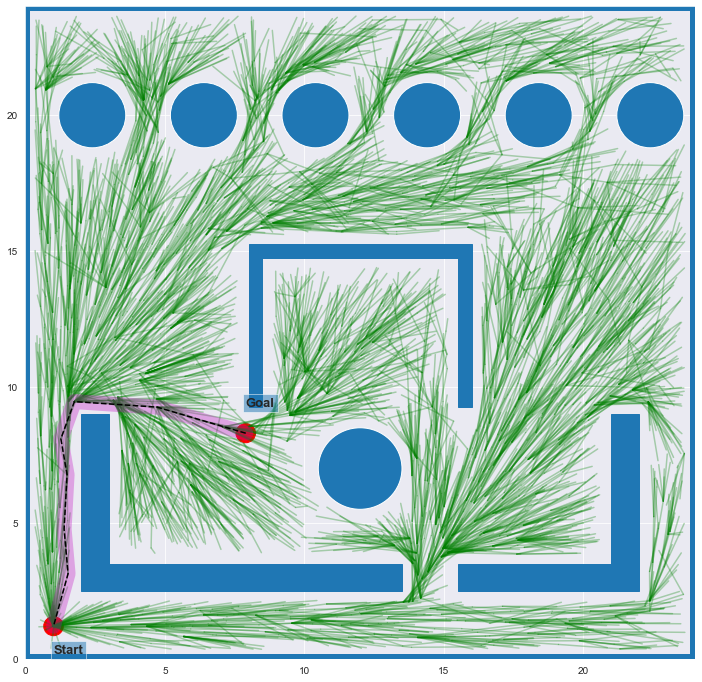

In [11]:
plot_path(path, x_s, x_g, x, y)

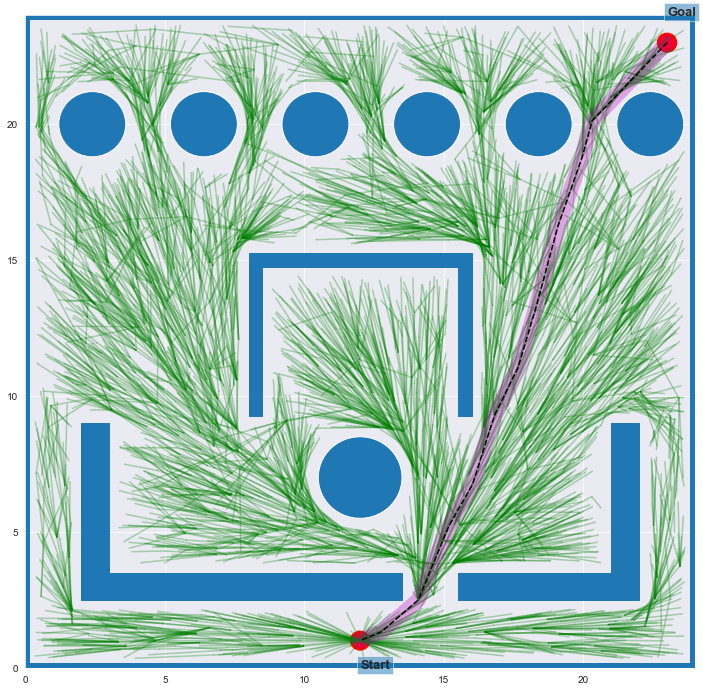

In [12]:
plot_path(path2, (12., 1,), (23., 23.), x2, y2)

## Question 2:
------------------
Plane height: 0.3 m
<br>
$ \vec{F} \, \in \, [5, 15] \, \hat z \quad [N] $ 
<br>
$ \rho _i = 1 \, kg/m $
<br>
$ m_{knife} = 0.5 \, kg $
<br>
Thin Rod

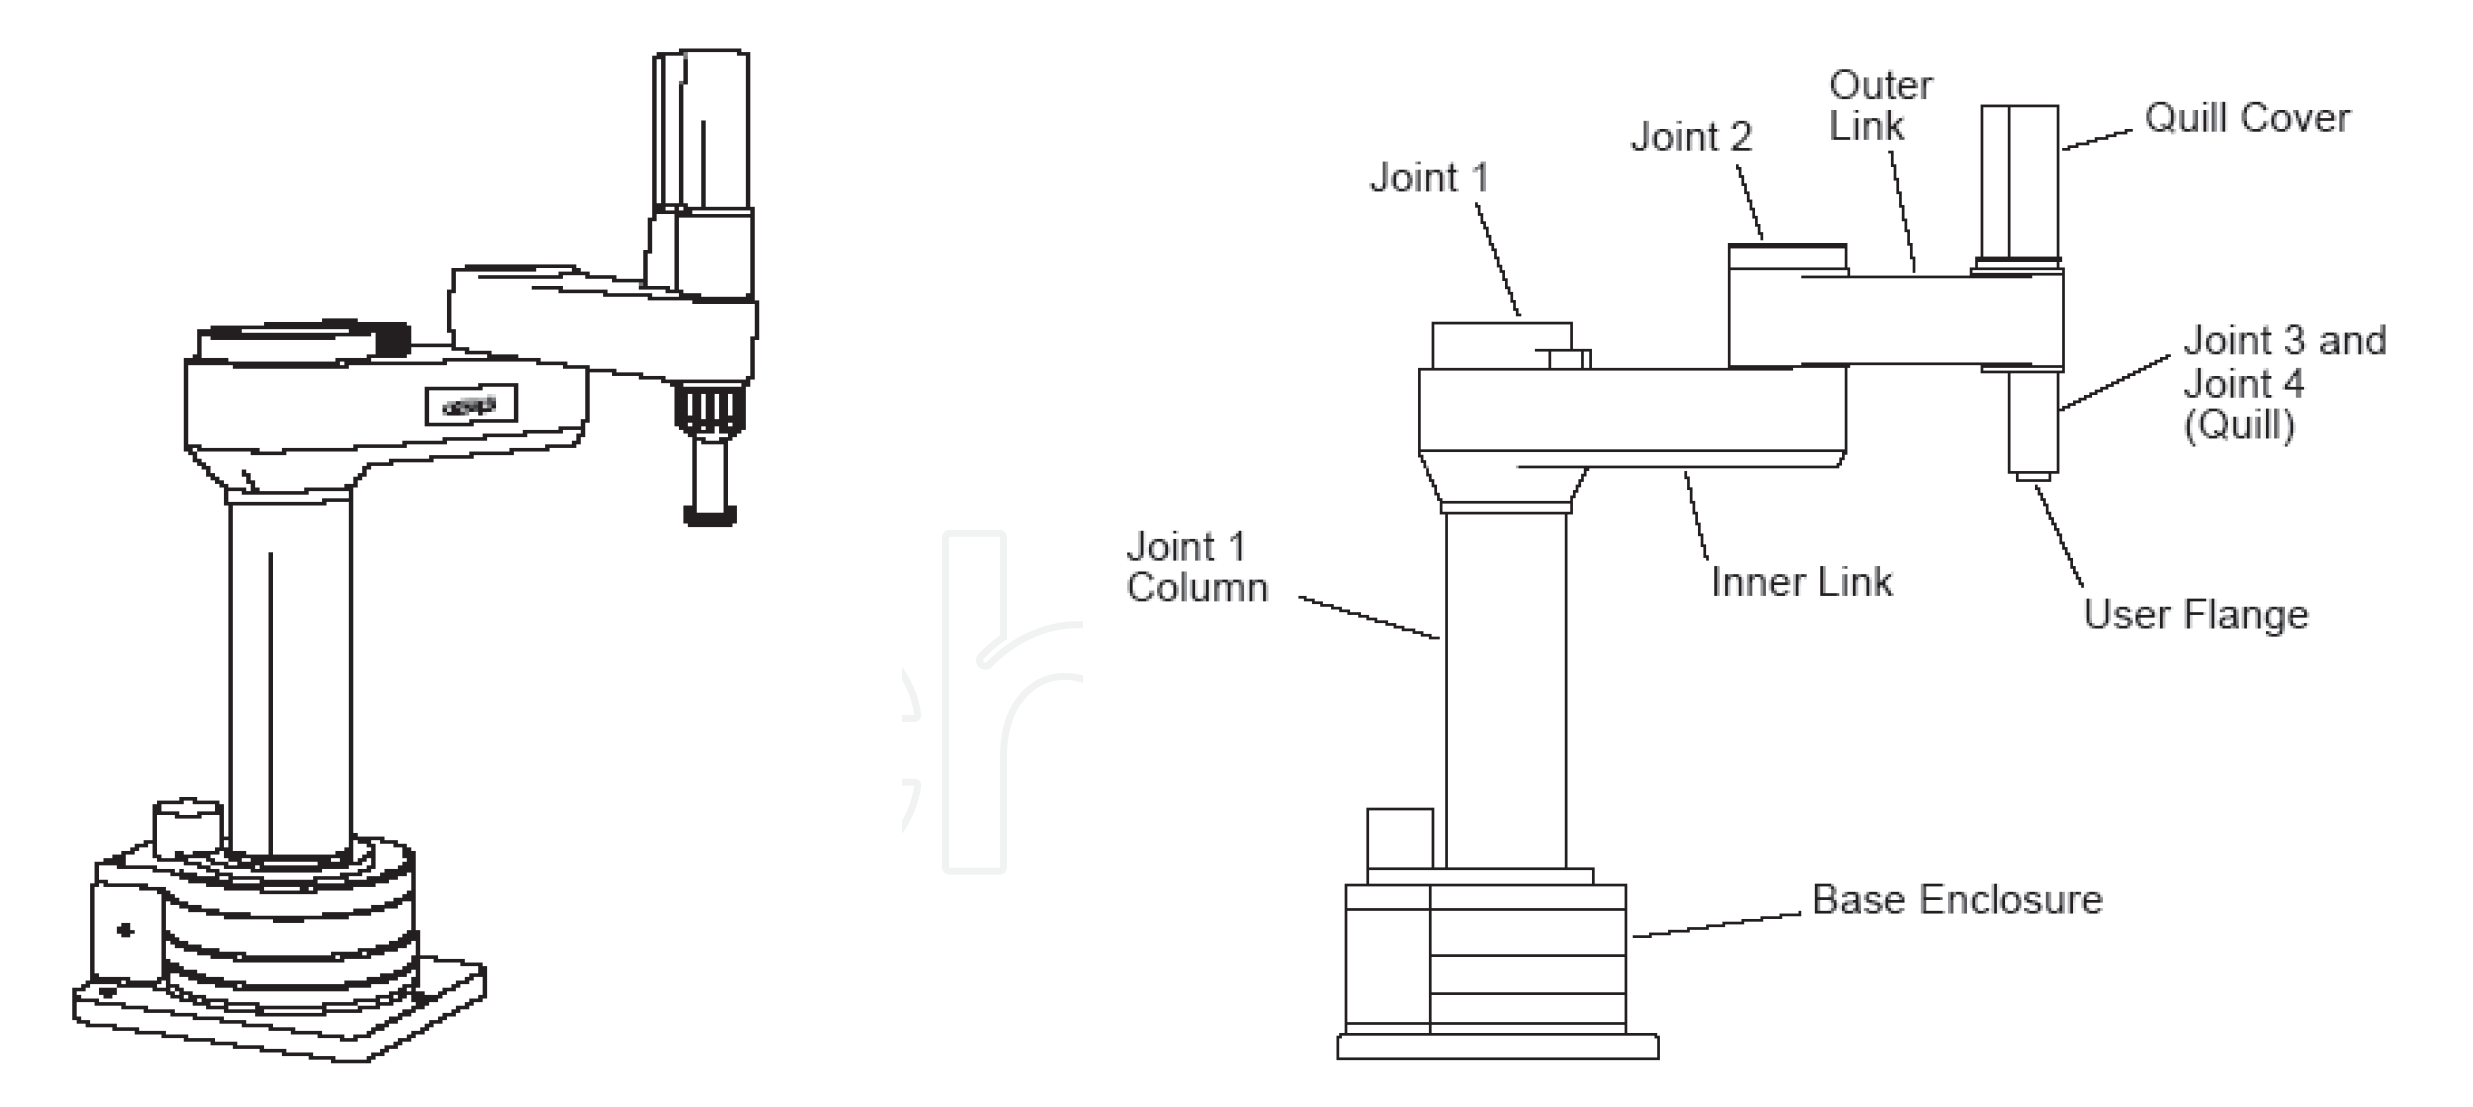

In [13]:
Image("Scara.png")

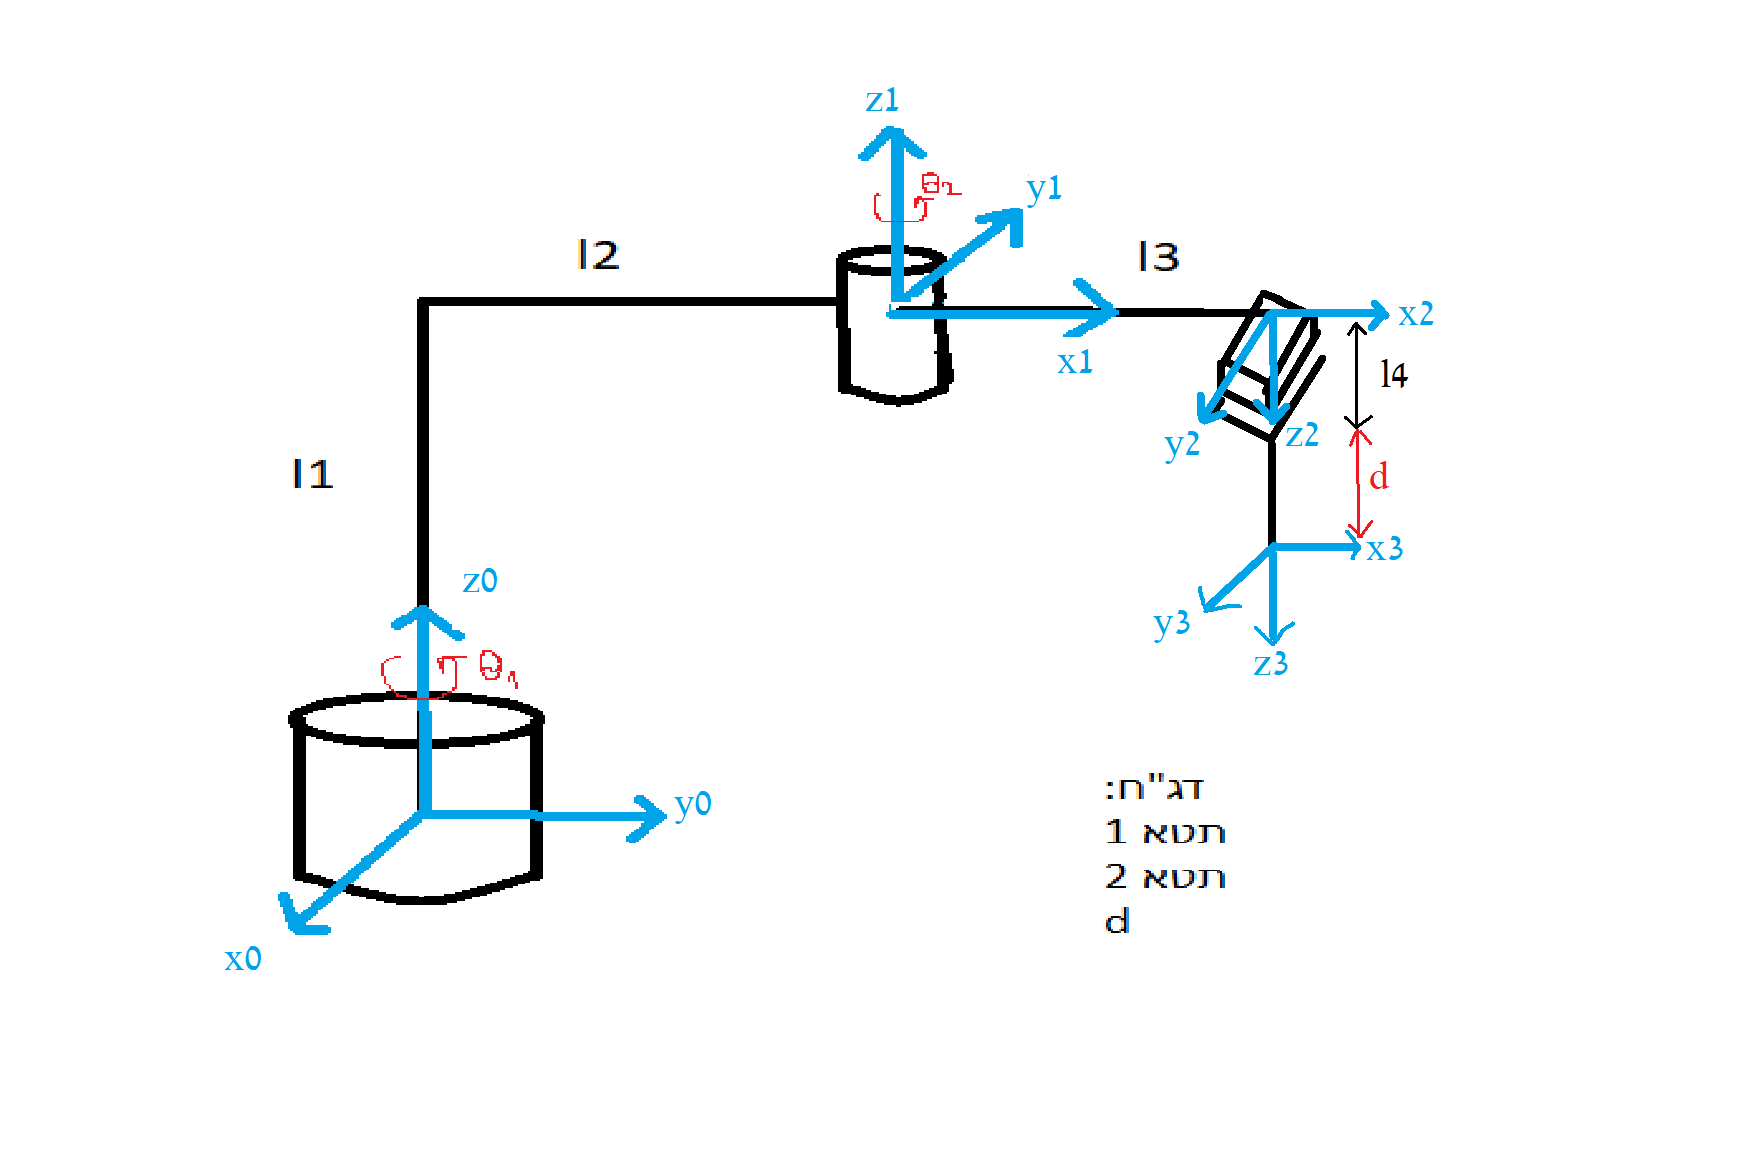

In [14]:
Image("DH_plot.png")

mass of rod 2: $ \quad m_2 = \int_{0}^{l_2} \rho dl = \rho l_2 = l_2 \, [kg]  $
<br>
mass of rod 3: $ \quad m_3 = \int_{0}^{l_3} \rho dl = \rho l_3 = l_3 \, [kg]  $
<br>
mass of rod 4: $ \quad m_4 = \int_{0}^{l_4} \rho dl = \rho l_4 = l_4 \, [kg]  $
<br>
mass of the knife: $ \quad m_{knife} = 0.5 \, [kg] $
<br>
thus, mass of link 4: $ m_d = m_4 + m_{knife} = 0.5 + l_4 \, [kg] $
<br>
Inertia moment of rod 2, at center of mass 2 l2/2:
$ \quad
\begin{equation*}
I_2 = 
\begin{pmatrix}
0 & 0 & 0\\
0 & \frac{m_2 l_2^2}{12} & 0\\
0 & 0 & \frac{m_2 l_2^2}{12}
\end{pmatrix}
\end{equation*}
$

Inertia moment of rod 3, at center of mass 3 l3/2:
$ \quad
\begin{equation*}
I_3 = 
\begin{pmatrix}
0 & 0 & 0\\
0 & \frac{m_3 l_3^2}{12} & 0\\
0 & 0 & \frac{m_3 l_3^2}{12}
\end{pmatrix}
\end{equation*}
$

#### #Note: Robot work space shown later $ \downarrow $

In [15]:
theta1, l1, theta2, l2, l3, l4, d, F, t, tau1, tau2, f, m2, m3, md, I2, I3, g = symbols('theta1 l1 theta2 l2 l3 l4 d F t tau1 tau2 f m2 m3 md I2 I3 g')
theta1 = Function('theta1')(t)
theta2 = Function('theta2')(t)
d = Function('d')(t)

In [16]:
I2_ten = np.array([[0, 0, 0], [0, I2, 0], [0, 0, I2]]) #I2 = (m2*l2**2)/12
I3_ten = np.array([[0, 0, 0], [0, I3, 0], [0, 0, I3]]) #I3 = (m3*l3**2)/12
g = np.array([[0], [0], [-9.81]])

### Direct kinematics (DH):
---------------------------

In [17]:
def DH(a, alpha, d, theta):
    return np.array([[cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)], 
                     [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)], 
                     [0, sin(alpha), cos(alpha), d], [0, 0, 0, 1]])

| $A^i _{i+1}$ | $a _i $ | $ \alpha _i $   | $ d _i $ | $ \theta _i $
|------|------|------|------|------|
|$ A^0 _ 1 $|   $l_2$  | 0 | $l_1$ |$ \theta _1 $|
|$ A^1 _ 2 $|   $l_3$  | $\pi $ | $0$ |$ \theta _2 $|
|$ A^2 _ 3 $|   $0$  | $0 $ | $ l_4 + d $ |$ 0 $|

In [18]:
A01 = DH(l2, 0, l1, theta1)
A12 = DH(l3, pi, 0, theta2)
A23 = DH(0, 0, l4+d, 0)

In [19]:
A03 = A01 @ A12 @ A23

#### Direct Kinematics $ \, A^0 _3 $:

In [20]:
simplify(A03)

[[cos(theta1(t) + theta2(t)), sin(theta1(t) + theta2(t)), 0, l2*cos(theta1(t)) + l3*cos(theta1(t) + theta2(t))], [sin(theta1(t) + theta2(t)), -cos(theta1(t) + theta2(t)), 0, l2*sin(theta1(t)) + l3*sin(theta1(t) + theta2(t))], [0, 0, -1, l1 - l4 - d(t)], [0, 0, 0, 1]]

In [21]:
def direct_kinematics(q):
    return [l2*np.cos(q[0]) + l3*np.cos(q[0]+q[1]), l2*np.sin(q[0]) + l3*np.sin(q[0]+q[1]), l1 - l4 - q[2]]

### Inverse Kinematics:
--------------------

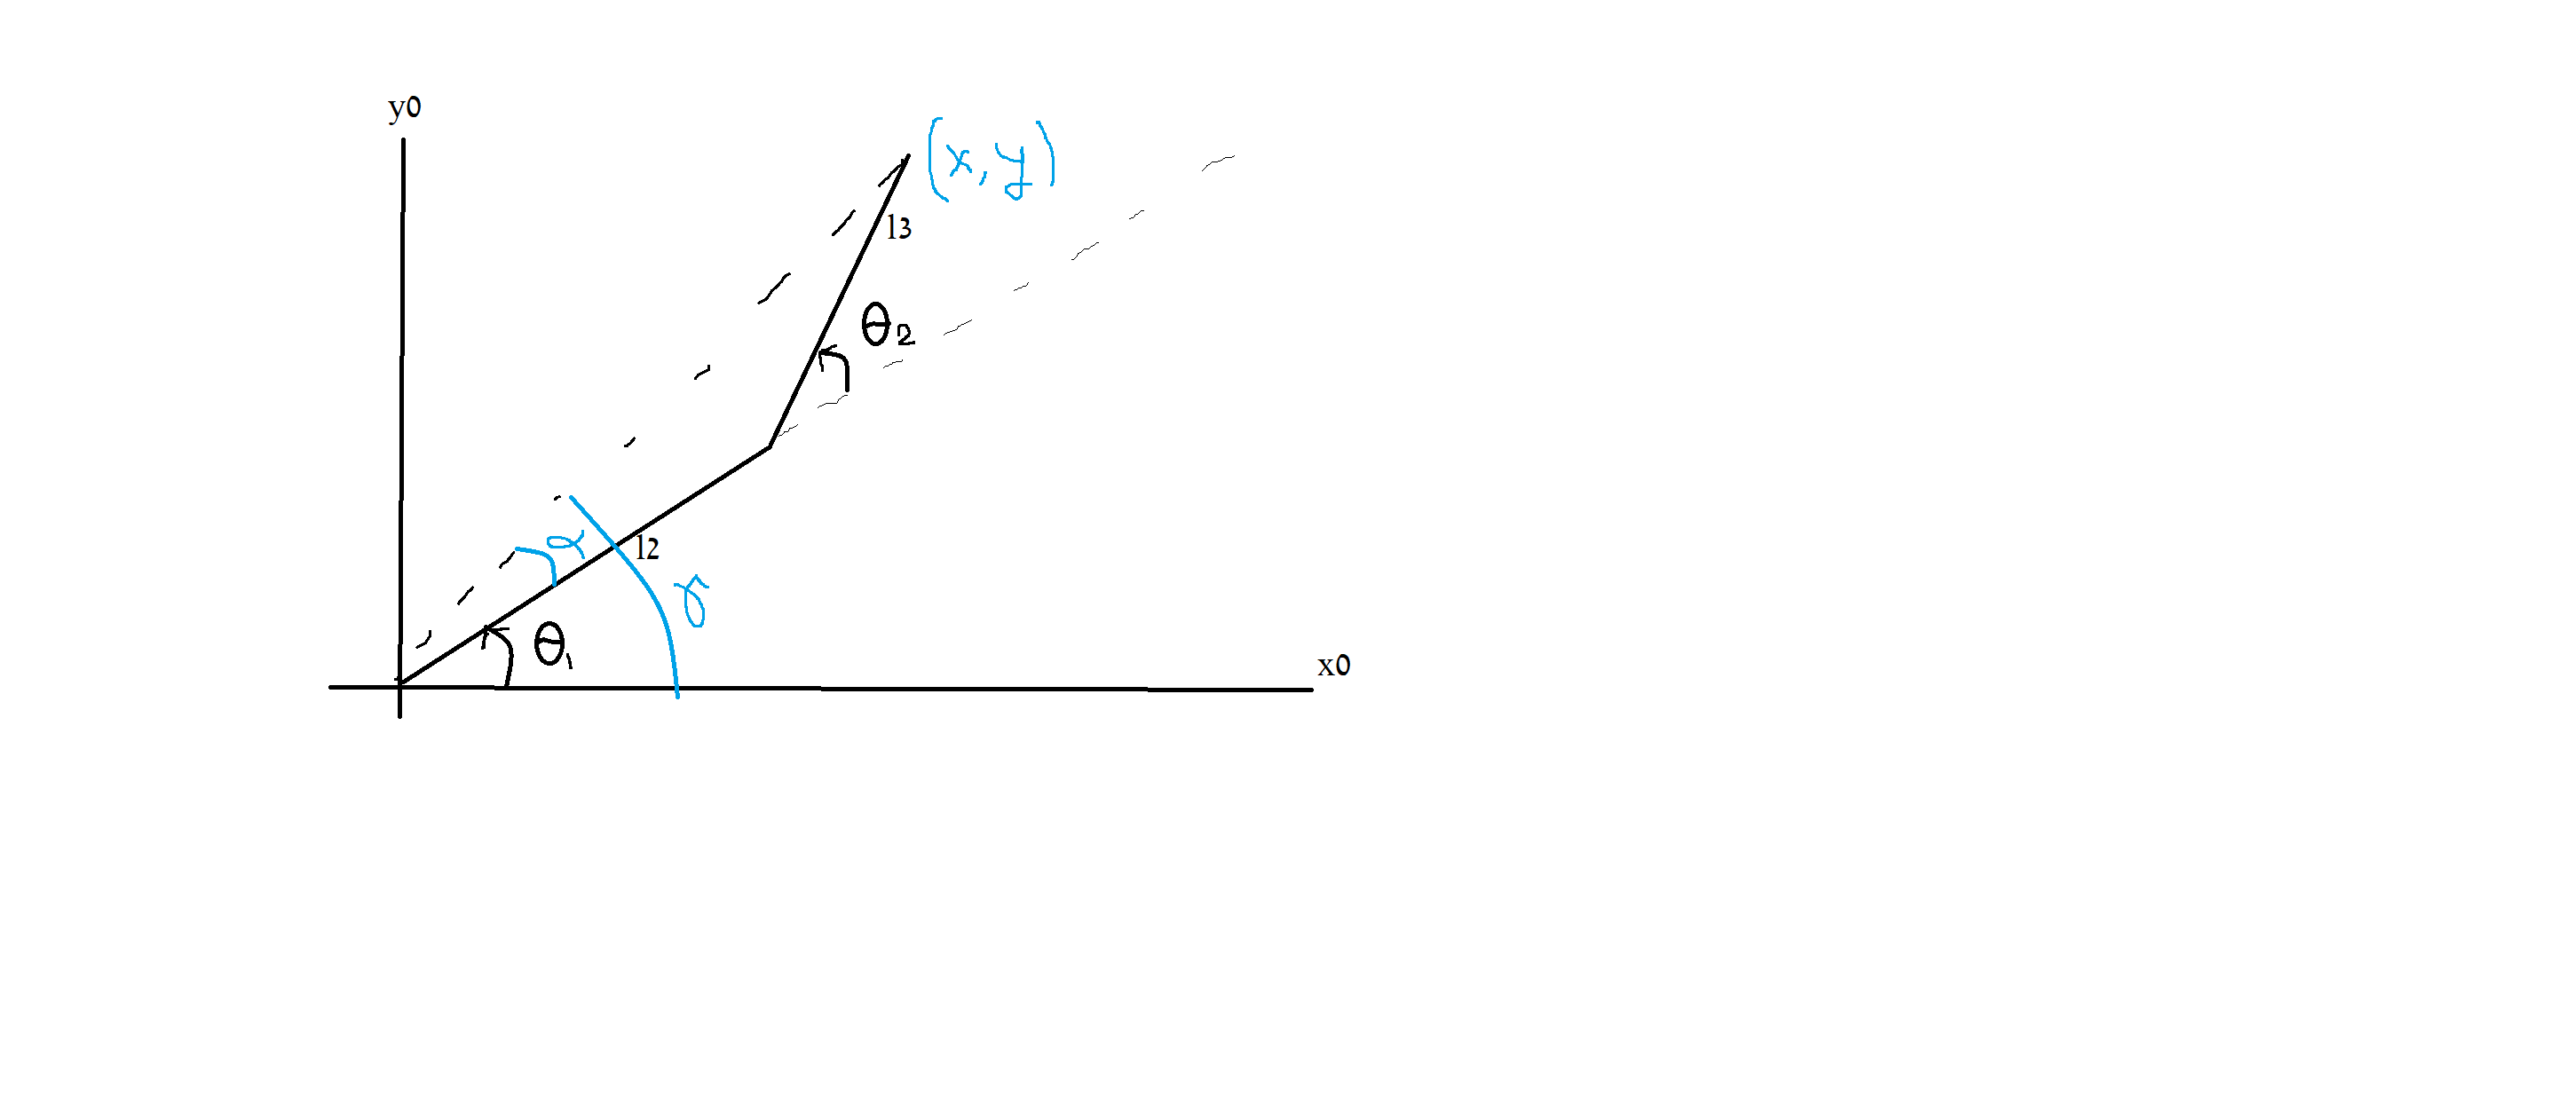

In [22]:
Image('Inverse_kin.png')

From cosines law:

<br>
$$ x^2 + y^2 = l_2 ^2 + l_3 ^2 -2l_2 l_3cos(\pi - (-\theta _2) ) $$
<br>
$$ cos(\pi + \theta _2 ) = -cos(\theta_2) $$
$$ \Downarrow $$
<br>
$$ cos(\theta _2) = \frac{x^2 + y^2 - l_2^2 - l_3^2}{2l_2 l_3} $$
<br>
$$ D = \frac{x^2 + y^2 - l_2^2 - l_3^2}{2l_2 l_3} $$
<br>
Elbow down:
$$ \theta_2 = atan2(\sqrt {1-D^2}, D) $$
<br>
<br>
$$ \gamma = arctan(\frac {y}{x}) $$
<br>
$$ \gamma = atan2(y, x) $$
<br>
<br>
$$ \alpha = atan2(l_3sin(\theta_2), l_2+l_3cos(\theta_2)) $$
<br>
$$ \Downarrow $$
<br>
$$ \theta _1 = \gamma - \alpha $$
<br>
$$ \theta _1 = atan2(y, x) - atan2(l_3sin(\theta_2), l_2+l_3cos(\theta_2)) $$
<br>
$ {\bf Thus, \,  inverse\, kinematics \, formulas \, are:} $
<br>
-------------------------------
<br>
$$ \theta _1 = atan2(y, x) - atan2(l_3sin(\theta_2), l_2+l_3cos(\theta_2)) $$
<br>
$$ \theta_2 = atan2(\sqrt {1-D^2}, D) $$
<br>
$$ d = z_0 + l_4 - l_1 $$
<br>
-------------------------------
<br>
while demanding cut at $ z_0 = 0.3 m $ height:
<br>
$$ d = 0.3 + l_4 - l_1 $$

In [23]:
def inverse_kinematics(x, y, z):
    D = (x**2 + y**2 - l2**2 - l3**2)/(2*l2*l3)
    theta2 = np.arctan2((1-D**2)**0.5, D) 
    theta1 = np.arctan2(y, x) - np.arctan2(l3*np.sin(theta2), l2 + l3*np.cos(theta2))
    d = l1 - l4 - z
    return theta1, theta2, d

### Jacobian:
---------------------

#### Calculating jacobian:

for $Linear \, coordinate$ :

$$ \quad
\begin{equation*}
\begin{pmatrix}
J_{Li} \\
J_{Ai}\\
\end{pmatrix}
 = 
\begin{pmatrix}
\hat {b}_{i-1}\\
0
\end{pmatrix}
\end{equation*}
$$

for $Angular \, coordinate$ :

$$ \quad
\begin{equation*}
\begin{pmatrix}
J_{Li} \\
J_{Ai}\\
\end{pmatrix}
 = 
\begin{pmatrix}
\hat {b}_{i-1} \times \vec r _{i-1}\\
\hat {b}_{i-1}
\end{pmatrix}
\end{equation*}
$$

Thus, the entire jacobian:

$$ \quad
\begin{equation*}
J = 
\begin{pmatrix}
J_{L1} & J_{L2} & J_{L3}\\
J_{A1} & J_{A2} & J_{A3}
\end{pmatrix}_{(6, 3)}
\end{equation*}
$$

In [24]:
# theta 1 and theta 2 are angular coordinates, while d is linear coordinate, thus:

b0 = np.array([[0], [0], [1]])
A02 = np.dot(A01, A12)
b1 = A01[:3, 2].reshape((3, 1))
b2 = A02[:3, 2].reshape((3, 1))
r0 = np.dot(A03, np.array([[0], [0], [0], [1]]))[:-1]
r1 = r0 - np.dot(A01, np.array([[0], [0], [0], [1]]))[:-1]
r2 = r0 - np.dot(A02, np.array([[0], [0], [0], [1]]))[:-1]

In [25]:
J_L1 = np.cross(b0.reshape(3,), r0.reshape(3,))
J_A1 = b0
J_L2 = np.cross(b1.reshape(3,), r1.reshape(3,))
J_A2 = b1
J_L3 = b2
J_A3 = np.array([[0],[0],[0]])

In [26]:
J1 = np.vstack((J_L1.reshape((3,1)), J_A1))
J2 = np.vstack((J_L2.reshape((3,1)), J_A2))
J3 = np.vstack((J_L3.reshape((3,1)), J_A3))

In [27]:
J = np.hstack((J1, np.hstack((J2, J3))))

In [28]:
simplify(J)

[[-l2*sin(theta1(t)) - l3*sin(theta1(t) + theta2(t)), -l3*sin(theta1(t) + theta2(t)), 0], [l2*cos(theta1(t)) + l3*cos(theta1(t) + theta2(t)), l3*cos(theta1(t) + theta2(t)), 0], [0, 0, -1], [0, 0, 0], [0, 0, 0], [1, 1, 0]]

## Computing dynamic equation (M, C, G):
----------------------

## $ M(\vec q) $ :
------------
 

### $$ M(\vec q) = \sum_{i=1}^{n} m_i J_{Li}^T J_{Li} + j_{Ai}^T  R_i^0 I_i^i R_i^{0^T}  J_{Ai} $$

$ J_{Li} $ - Linear jacobian to center mass of link i
<br>
$ J_{Ai} $ - Angular jacobian to center mass of link i
<br>
$ I_i^i $ - Inertia Tensor center mass coordinates of link i
<br>
$ R_i^0 $ - Rotation matrix from axis i to axis 0

In [29]:
jcl1 = np.array([[-0.5*l2*sin(theta1), 0, 0], [0.5*l2*cos(theta1), 0, 0], [0, 0, 0]])
jcl2 = np.array([[-l2*sin(theta1)-0.5*l3*sin(theta1+theta2), -0.5*l3*sin(theta1+theta2), 0], [l2*cos(theta1)+0.5*l3*cos(theta1+theta2), 0.5*l3*cos(theta1+theta2), 0], [0, 0, 0]])
jcl3 = J[:3,:]
jca1 = np.array([[0, 0, 0], [0, 0, 0], [1, 0, 0]])
jca2 = np.array([[0, 0, 0], [0, 0, 0], [1, 1, 0]])
jca3 = np.array([[0, 0, 0], [0, 0, 0], [1, 1, 0]])

In [30]:
I2_0 = DH(l2/2, 0, l1, theta1)[:-1,:-1] @ I2_ten @ DH(l2/2, 0, l1, theta1)[:-1,:-1].T
I3_0 = (A01[:-1,:-1] @ DH(l3/2, 0, 0, theta2)[:-1,:-1]) @ I3_ten @ (A01[:-1,:-1] @ DH(l3/2, 0, 0, theta2)[:-1,:-1]).T
M2 = m2*(jcl1.T @ jcl1) + jca1.T @ I2_0 @ jca1
M3 = m3*(jcl2.T @ jcl2) + jca2.T @ I3_0 @ jca2
M4 = md*(jcl3.T @ jcl3)

In [31]:
M = M2+M3+M4

In [32]:
simplify(M)

[[I2 + I3 + 0.25*l2**2*m2 + m3*(1.0*l2**2 + 1.0*l2*l3*cos(theta2(t)) + 0.25*l3**2) + md*(l2**2 + 2*l2*l3*cos(theta2(t)) + l3**2), I3 + 0.5*l3*m3*(1.0*l2*cos(theta2(t)) + 0.5*l3) + l3*md*(l2*cos(theta2(t)) + l3), 0], [I3 + 0.5*l3*m3*(1.0*l2*cos(theta2(t)) + 0.5*l3) + l3*md*(l2*cos(theta2(t)) + l3), I3 + 0.25*l3**2*m3 + l3**2*md, 0], [0, 0, md]]

In [33]:
simplify(M)

[[I2 + I3 + 0.25*l2**2*m2 + m3*(1.0*l2**2 + 1.0*l2*l3*cos(theta2(t)) + 0.25*l3**2) + md*(l2**2 + 2*l2*l3*cos(theta2(t)) + l3**2), I3 + 0.5*l3*m3*(1.0*l2*cos(theta2(t)) + 0.5*l3) + l3*md*(l2*cos(theta2(t)) + l3), 0], [I3 + 0.5*l3*m3*(1.0*l2*cos(theta2(t)) + 0.5*l3) + l3*md*(l2*cos(theta2(t)) + l3), I3 + 0.25*l3**2*m3 + l3**2*md, 0], [0, 0, md]]

## $ C(\vec q, \dot{\vec q})$:
--------------------
### $$ C(\vec q, \dot{\vec q}) = \dot M - \frac{1}{2} \dot{\vec q}^T \frac{\partial M}{\partial {\vec q}} $$

In [34]:
q = np.array([[theta1, theta2, d]])

In [35]:
dq = np.array([[diff(qi, t)] for qi in q[0]])
ddq = np.array([[diff(dqi[0], t)] for dqi in dq])
dm1 = [[], [], []]
dm2 = [[], [], []]
dm3 = [[], [], []]
m_dot = [[], [], []]
for row in [0, 1, 2]:
    for col in [0, 1, 2]:
        dm1[row].append(diff(M[row, col], theta1))
        dm2[row].append(diff(M[row, col], theta2))
        dm3[row].append(diff(M[row, col], d))
        m_dot[row].append(diff(M[row, col], t))
dM1 = np.array(dm1)
dM2 = np.array(dm2)
dM3 = np.array(dm3)
dM = np.array(m_dot)

In [36]:
stacked = 0.5*np.vstack((dq.T @ dM1, np.vstack((dq.T @ dM2, dq.T @ dM3))))
C = dM - stacked

In [37]:
simplify(C)

[[-l2*l3*(1.0*m3 + 2.0*md)*sin(theta2(t))*Derivative(theta2(t), t), -l2*l3*(0.5*m3 + 1.0*md)*sin(theta2(t))*Derivative(theta2(t), t), 0], [l2*l3*(0.5*m3*Derivative(theta1(t), t) - 0.25*m3*Derivative(theta2(t), t) + 1.0*md*Derivative(theta1(t), t) - 0.5*md*Derivative(theta2(t), t))*sin(theta2(t)), l2*l3*(0.25*m3 + 0.5*md)*sin(theta2(t))*Derivative(theta1(t), t), 0], [0, 0, 0]]

$$ \Downarrow \\
\quad
\begin{equation*}
C(\vec q, \dot {\vec q}) = 
\begin{pmatrix}
-l_2l_3(m_3 + 2m_d)sin(\theta_2) \dot {\theta _2} & -l_2l_3(0.5m_3 + m_d)sin(\theta_2) \dot {\theta _2} & 0\\
l_2l_3 (0.5m_3 \dot {\theta_1 } + m_d \dot{\theta _1})sin(\theta _2)& 0 & 0\\
0 & 0 & 0
\end{pmatrix}
\end{equation*}
$$

## $ G(\vec q) $:
-----------------------
### $$ ( \sum_{i=1}^{n} m_i J_{Li}^T) \vec g ^{(0)} $$

In [38]:
summ = m2*jcl1.T + m3*jcl2.T + md*jcl3.T 
G = summ @ g

In [39]:
simplify(G)

[[0], [0], [9.81*md]]

## $ \vec {\tau} , J^T \vec F :$
-------

In [40]:
JTF = np.dot(J.T, np.array([[0], [0], [F], [0], [0], [0]]))
Q = np.array([[tau1], [tau2], [f]]) + JTF
simplify(Q)

[[tau1], [tau2], [-F + f]]

### $$ M(\vec q) \ddot{\vec q} + C(\vec q , \dot{\vec q})\dot{\vec q} + G(\vec q) = \vec \tau + J^T \vec F$$

In [41]:
l1 = 0.5
m2 = l2 = 0.6
m3 = l3 = 0.5
m4 = l4 = 0.1
md = m4 + 0.5
I2 = (m2*l2**2)/12
I3 = (m3*l2**2)/12

#### As said previously, Robot work space:

In [73]:
q1 = np.random.randint(-180, 180, 10000)
q1 = (q1*np.pi)/180
q2 = np.random.randint(-180, 180, 10000)
q2 = (q2*np.pi)/180

df = pd.DataFrame({'q1' : q1, 'q2' : q2})
df['q'] = df.apply(lambda row: [row.q1, row.q2, 0.1], axis = 1) 
df['xyz'] = df.q.apply(direct_kinematics)
df['x'] = df.xyz.apply(lambda x: x[0])
df['y'] = df.xyz.apply(lambda x: x[1])

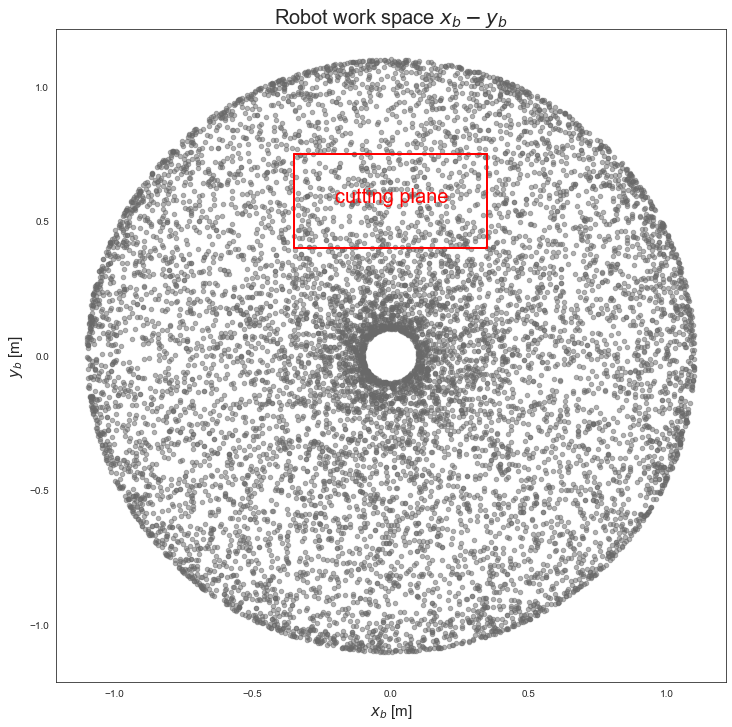

In [74]:
sns.set_style('white')
plt.figure(figsize=(12, 12))
plt.title('Robot work space $x_b - y_b $', fontsize=20)
plt.xlabel('$x_b$ [m]', fontsize=15)
plt.ylabel('$y_b$ [m]', fontsize=15)
plt.plot([-0.35, 0.35], [0.75, 0.75], color='r', lw=2)
plt.plot([-0.35, 0.35], [0.4, 0.4], color='r', lw=2)
plt.plot([-0.35,- 0.35], [0.4, 0.75], color='r', lw=2)
plt.plot([0.35, 0.35], [0.4, 0.75], color='r', lw=2)
plt.text(-0.2, 0.57, 'cutting plane', color='r', fontsize=20)
plt.scatter(df.x, df.y, c='dimgray', s=20, alpha=0.5)

### Control system:
----------

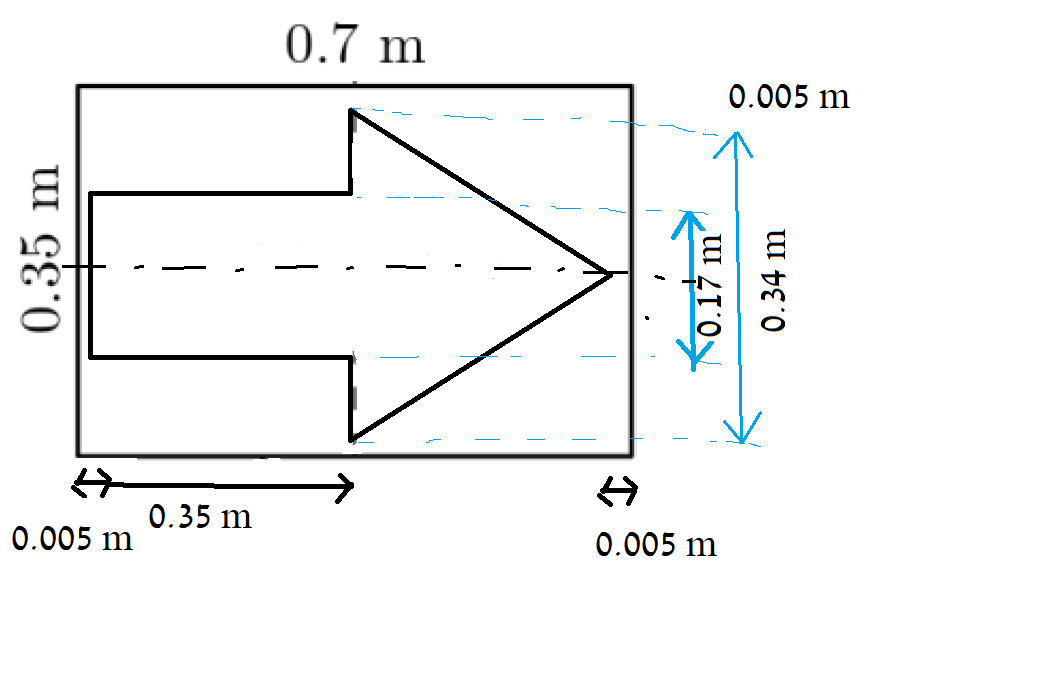

In [44]:
Image('arrow.png')

## Tracking Control $\Rightarrow $ Computed Torque Control:
------------------------

$$ \vec {\tau} = M(\vec q)(\ddot{\vec {q_d}} - k_d \dot{\vec e} - k_p \vec e) + C(\vec q, \dot{\vec q}) \dot{\vec q} + G(\vec q) \\
\vec e = \vec q - \vec {q_d} \\
M(\ddot{\vec q} - \ddot{\vec {q_d}} + k_d \dot{\vec e} + k_p \vec e) = 0 \, /*M^{-1} \\
\Downarrow \\
\ddot{\vec {e}} + k_d \dot{\vec e} + k_p \vec e = 0
$$

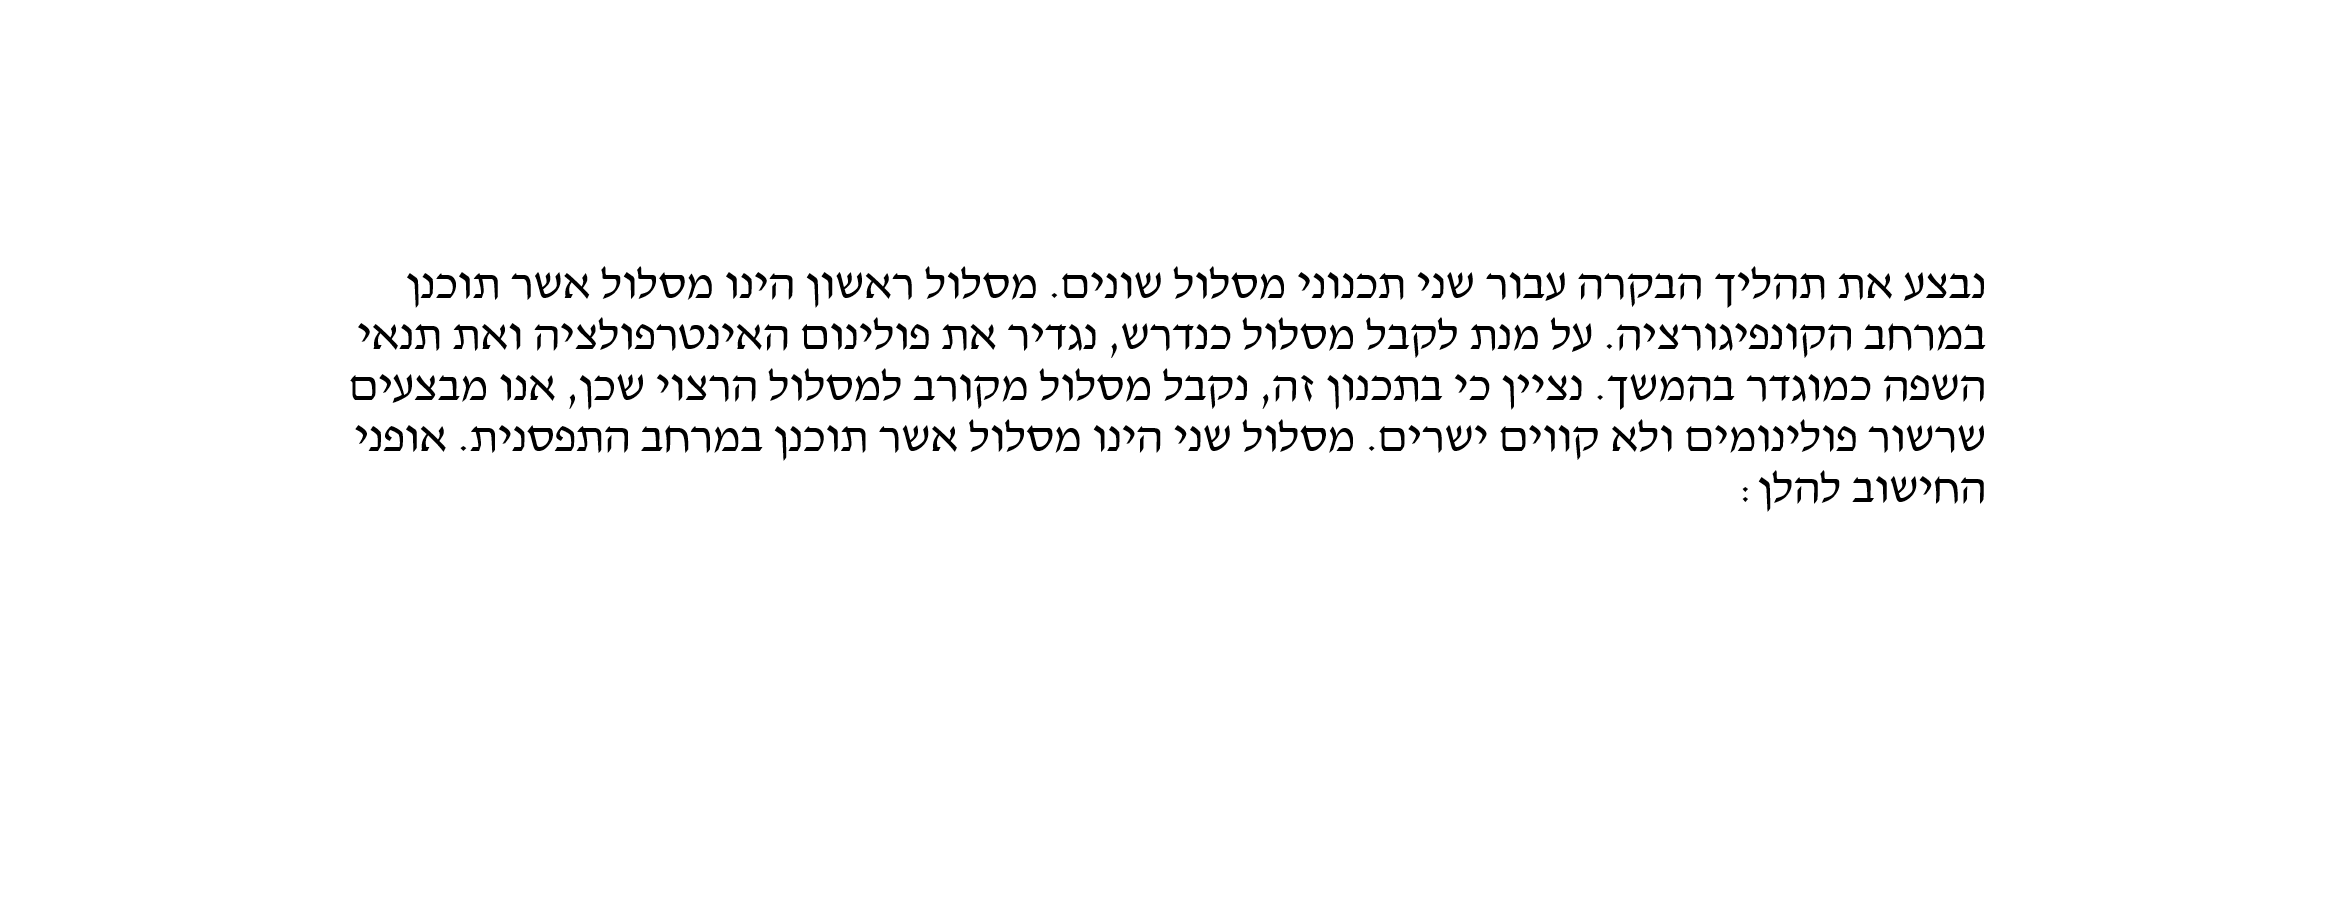

In [45]:
Image('task_conf.png')

### Path plan: calculating polynomial interpulation Configuration Space:
-------------------

$$ q = a_0 + a_1t + a_2 t^2 + a_3 t^3 +a_4 t^4 $$
<br>
$$ conditions: $$
<br>
- $$ q(0) = q_{start} = q_1 $$
<br>
- $$ q(T_f) = q_{goal} = q_2 $$
<br>
- $$ q(\frac {T_f}{2}) = q_{middle} = q_m $$
<br>
- $$ \dot q (0) = 0 $$
<br>
- $$ \dot q (T_f) = 0 $$
<br>
$$ \Downarrow $$
$$ a_4 = \frac{q_m - 0.5(q_1 + q_2)}{(\frac{T_f}{2})^4} $$
<br>
$$ a_3 = -2(a_4 T_f - \frac{q_1-q_2}{T_f ^3}) $$
<br>
$$ a_2 = -\frac{3}{2} a_3T_f - 2 a_4 T_f ^2 $$
<br>
$$ a_1 = 0 $$
<br>
$$ a_0 = q_1 $$


### Path plan: calculating polynomial interpulation Task Space:
-------------------


$$ x = x_s + s(t)(x_g - x_s) $$
<br>
$$ \dot {x} = \dot s (x_g - x_s) $$
<br>
$$ \ddot {x} = \ddot s (x_g - x_s) $$
<br>
$$ s(t) = a_0 + a_1t + a_2 t^2 + a_3 t^3 $$
<br>
$$ \dot s(t) = a_1 + 2 a_2 t + 3 a_3 t^2 $$
<br>
$$ \ddot s(t) = 2 a_2 + 6 a_3 t $$
<br>
$$ conditions: $$
<br>
- $$ s(0) = 0 $$
<br>
$$ \Downarrow $$
<br>
$$ a_0 = 0 $$
<br>
- $$ s(T_f) =  1 $$
<br>
$$ \Downarrow $$
<br>
$$ a_2 T_f ^2  + a_3 T_f ^3 = 1 $$ 
<br>
- $$ \dot {x(t=0)} = 0 $$
<br>
$$ \Downarrow $$
<br>
$$\dot s(0) (x_g - x_s) = 0$$
<br>
$$ \Downarrow $$
<br>
$$ a_1 = 0 $$
<br>
- $$ \dot {x(t=T_f)} = 0 $$
<br>
$$ \Downarrow $$
<br>
$$\dot s(T_f) (x_g - x_s) = 0$$
<br>
$$ \Downarrow $$
<br>
$$ a_2 = -\frac{3}{2} a_3 T_f $$
<br>
$$ a_3 = -\frac{2}{T_f ^3} $$
<br>
$$ a_2 = \frac {3}{T_f ^2} $$
<br>
$$ \Downarrow $$
<br>
$$ x = x_s + (\frac {3}{T_f ^2} t^2 + -\frac{2}{T_f ^3} t^3)(x_g - x_s) $$
<br>
$$ \Downarrow $$
<br>
$$ \dot x = (\frac {6}{T_f ^2} t + -\frac{6}{T_f ^3} t^2)(x_g - x_s) $$
<br>
$$ \Downarrow $$
<br>
$$ \ddot x = (\frac {6}{T_f ^2} + -\frac{12}{T_f ^3} t)(x_g - x_s) $$

#### Now we need to map the locations velocitys and accelerations back to configuration space: 
---
$$ \vec q = inverse-kinematics(\vec x) $$
<br>
$$ \dot {\vec q} = J^{-1} \dot {\vec x} $$
<br>
$$ \ddot {\vec q} = J^{-1} (\ddot {\vec x} - \dot J \dot {\vec q}) $$


#### In order to deside the values of Kp and Kd we need to examine:
---
$$ 
K_{pi} = \omega _{i} ^2 \\
K_{di} = \xi _i \omega _i\\
where \, \omega _{i} \, is \, Natural \, frequency \, and \,  \xi _{i} \, is \, Damping \, Ratio \\
$$ thus: 
$$ \quad
\begin{equation*}
K_p = 
\begin{pmatrix}
\omega _{1} ^2 & 0 & 0\\
0 & \omega _{2} ^2 & 0\\
0 & 0 & \omega _{3} ^2
\end{pmatrix}
\end{equation*} $$

$$
\quad
\begin{equation*}
K_d = 
\begin{pmatrix}
2 \xi _1 \omega _1 & 0 & 0\\
0 & 2 \xi _2 \omega _2 & 0\\
0 & 0 & 2 \xi _3 \omega _3
\end{pmatrix}
\end{equation*}
$$

Since knife Z location <b>cannot</b> be smaller than 0.3m (knife penetration is prohibited!) we demand:
$$ \xi _3 \geq  0.707 $$
<br>
also, we choose:
$$ \xi _{1, 2} = 0.707 $$

In [46]:
u_list1 = [[],[],[]]
u_list2 = [[],[],[]]
def computed_torque( q, dq, qd, dqd, ddqd):
    Kp = np.diag([30, 30, 10000]) 
    Kd = np.diag([np.sqrt(2*30), np.sqrt(2*30), 180])
    M = np.array([[I2 + I3 +0.25*m2*(l2**2) + m3*(l2**2 + l2*l3*np.cos(q[1]) + 0.25*l3**2) + md*(l2**2 + 2*l2*l3*np.cos(q[1]) + l3**2),
                  I3 + 0.5*l3*m3*(l2*np.cos(q[1])+0.5*l3) + l3*md*(l2*np.cos(q[1]) + l3), 0],
                 [I3 + 0.5*l3*m3*(l2*np.cos(q[1]) + 0.5*l3) + l3*md*(l2*np.cos(q[1]) + l3), I3 + 0.25*(l3**2)*m3 + md*(l3**2), 0], 
                 [0, 0, md]])
    C = np.array([[-l2*l3*(m3*2*md)*np.sin(q[1])*dq[1], -l2*l3*(0.5*m3 + md)*np.sin(q[1])*dq[1], 0],
                 [l2*l3*(0.5*m3*dq[0] - 0.25*m3*dq[1] + md*dq[0] - 0.5*md*dq[1])*np.sin(q[1]), l2*l3*(0.25*m3 + 0.5*md)*np.sin(q[1])*dq[0], 0],
                 [0, 0, 0]])
    G = np.array([0, 0, 9.81*md])
    v = ddqd - Kd.dot(dq - dqd) - Kp.dot(q - qd)

    u = M.dot( v ) + C.dot( dq ) + G
    return u, M, C, G

def traj_gen(q1, q2, qm, t, Tf):
    '''path plan configuration space'''
    a0 = q1
    a1 = np.zeros((3,))
    a4 = (qm - 0.5*(q1 + q2))/((Tf/2)**4)
    a3 = (2*(q1 - q2) / (Tf**3)) - 2*Tf *a4
    a2 = -1.5 * a3 * Tf - 2*a4* Tf**2

    q = a0 + a1*t + a2 * t**2 + a3 * t**3 + a4 * t**4
    dq = a1 + 2*a2*t + 3*a3*t**2 + 4*a4*t**3
    ddq = 2*a2 + 6*a3*t + 12*a4*t**2
    

    return q, dq, ddq

def traj_gen2(q1, q2, qm, t, Tf):
    '''path plan task space'''
    x_s = np.array(direct_kinematics(q1))
    x_g = np.array(direct_kinematics(q2))
    a0 = np.zeros((3,))
    a1 = np.zeros((3,))
    a2 = 3/Tf**2
    a3 = -2/Tf**3
    x = x_s + (a0+a1*t + a2*t**2 + a3*t**3)*(x_g - x_s)
    dx = (a1 + 2*a2*t + 3*a3*t**2)*(x_g - x_s)
    ddx = (2*a2 + 6*a3*t)*(x_g - x_s)
    q = np.array([inverse_kinematics(x[0], x[1], x[2])])
    J = np.array([[-l2*np.sin(q[:,0][0]) - l3*np.sin(q[:,0][0]+q[:,1][0]), -l3*np.sin(q[:,0][0] + q[:,1][0]), 0],
                   [l2*np.cos(q[:,0][0]) + l3*np.cos(q[:,0][0] + q[:,1][0]), l3*np.cos(q[:,0][0] + q[:,1][0]), 0],
                   [0, 0, -1]])

    J_1 = np.linalg.inv(J)
    dq = J_1 @ np.array([[dx[0]], [dx[1]], [dx[2]]])
    
    dJ = np.array([[-l2*np.cos(q[0,0])*dq[0,0] - l3*np.cos(q[0,0]+q[0,1])*(dq[0,0] + dq[1,0]), -l3*np.cos(q[0, 0] + q[0, 1])*(dq[0,0] + dq[1,0]), 0],
                   [-l2*np.sin(q[0,0])*dq[0,0] - l3*np.sin(q[0,0] + q[0,1])*(dq[0,0] + dq[1,0]), -l3*np.sin(q[0,0] + q[0,1])*(dq[0,0] + dq[1,0]), 0],
                   [0, 0, 0]])
    
    ddq = J_1 @ ( ddx - (dJ@dq).reshape((3,)))

    return q.reshape((3,)), dq.reshape((3,)), ddq.reshape((3,))

# ------ ODE ------

def model1(x, t, x0, xg, Tf, xm, F, change_u):
    '''model 1 - configuration space path plan'''
    x1 = x[:3] # q
    x2 = x[3:] # dq
    qd, dqd, ddqd = traj_gen(x0[:3], xg[:3], xm, t, Tf)
    u, M , C, G= computed_torque(x1, x2, qd, dqd, ddqd)
    
    if change_u:
        u_list1[0].append(u[0])
        u_list1[1].append(u[1])
        u_list1[2].append(u[2])
    
    invM = np.linalg.inv(M)
    F = np.array([0, 0, F])
    dx1 = x2
    dx2 = invM.dot(u - C.dot(x2) - G - F)
    dxdt = np.concatenate((dx1, dx2), axis = 0)

    return dxdt


def model2(x, t, x0, xg, Tf, xm, F, change_u):
    '''model 1 - task space path plan'''
    x1 = x[:3] # q
    x2 = x[3:] # dq
    qd, dqd, ddqd = traj_gen2(x0[:3], xg[:3], xm, t, Tf)
    u, M , C, G= computed_torque(x1, x2, qd, dqd, ddqd)
    if change_u:
        u_list2[0].append(u[0])
        u_list2[1].append(u[1])
        u_list2[2].append(u[2])
    
    invM = np.linalg.inv(M)
    F = np.array([0, 0, F])
    dx1 = x2
    dx2 = invM.dot(u - C.dot(x2) - G - F)
    dxdt = np.concatenate((dx1, dx2), axis = 0)

    return dxdt

# ------ Solve ------

Tf = 3.
t = np.linspace(0, Tf, 100)
q00 = inverse_kinematics(-0.345, 0.66, 0.4) 
qs = inverse_kinematics(-0.345, 0.66, 0.3)
qm = inverse_kinematics(-0.345/2, 0.66, 0.3)
qg = inverse_kinematics(0., 0.66, 0.3)
qm2 = inverse_kinematics(0, (0.745 + 0.66)/2, 0.3)
qg2 = inverse_kinematics(0., 0.745, 0.3)
qm3 = inverse_kinematics(0.345/2, (0.745+0.575)/2, 0.3)
qg3 = inverse_kinematics(0.345, 0.575, 0.3)
qm4 = inverse_kinematics(0.345/2, (0.575+0.405)/2, 0.3)
qg4 = inverse_kinematics(0., 0.405, 0.3)
qm5 = inverse_kinematics(0., (0.49+0.405)/2, 0.3)
qg5 = inverse_kinematics(0., 0.49, 0.3)
qm6 = inverse_kinematics(-0.345/2, 0.49, 0.3)
qg6 = inverse_kinematics(-0.345, 0.49, 0.3)
qm7 = inverse_kinematics(-0.345, 0.4 + 0.35/2, 0.3)
x00 = np.array([q00[0], q00[1], q00[2], 0, 0, 0])
x0 = np.array([qs[0], qs[1], 0.1, 0, 0, 0])

xm0 = np.array([q00[0], q00[1], (q00[2]+0.1)/2])
xm = np.array([qm[0], qm[1], 0.1])
xm2 = np.array([qm2[0], qm2[1], 0.1])
xm3 = np.array([qm3[0], qm3[1], 0.1])
xm4 = np.array([qm4[0], qm4[1], 0.1])
xm5 = np.array([qm5[0], qm5[1], 0.1])
xm6 = np.array([qm6[0], qm6[1], 0.1])
xm7 = np.array([qm7[0], qm7[1], 0.1])
xg = np.array([qg[0], qg[1], 0.1, 0, 0, 0])
xg2 = np.array([qg2[0], qg2[1], 0.1, 0, 0, 0])
xg3 = np.array([qg3[0], qg3[1], 0.1, 0, 0, 0])
xg4 = np.array([qg4[0], qg4[1], 0.1, 0, 0, 0])
xg5 = np.array([qg5[0], qg5[1], 0.1, 0, 0, 0])
xg6 = np.array([qg6[0], qg6[1], 0.1, 0, 0, 0])

def ode_1(F, change_u=True):
    Q0 = odeint(model1, x00, t, args=(x00, x0, Tf, xm0, F, change_u))
    Q1 = odeint(model1, x0, t, args=(x0, xg, Tf, xm, F, change_u))
    Q2 = odeint(model1, xg, t, args=(xg, xg2, Tf, xm2, F, change_u))
    Q3 = odeint(model1, xg2, t, args=(xg2, xg3, Tf, xm3, F, change_u))
    Q4 = odeint(model1, xg3, t, args=(xg3, xg4, Tf, xm4, F, change_u))
    Q5 = odeint(model1, xg4, t, args=(xg4, xg5, Tf, xm5, F, change_u))
    Q6 = odeint(model1, xg5, t, args=(xg5, xg6, Tf, xm6, F, change_u))
    Q7 = odeint(model1, xg6, t, args=(xg6, x0, Tf, xm7, F, change_u))
    Q = np.vstack((Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7))
    X = np.array([direct_kinematics(q) for q in Q])

    lst = [x00, x0, xg, xg2, xg3, xg4, xg5, xg6, x0]
    lst2 = [xm0, xm, xm2, xm3, xm4, xm5, xm6, xm7]

    Qd = np.vstack(tuple(np.array([traj_gen(lst[ind-1][:3], lst[ind][:3], lst2[ind-1], tt, Tf)[0] for tt in t]) for ind in range(1,9)))
    dQd = np.vstack(tuple(np.array([traj_gen(lst[ind-1][:3], lst[ind][:3], lst2[ind-1], tt, Tf)[1] for tt in t]) for ind in range(1,9)))
    X2 = np.array([direct_kinematics(q) for q in Qd])
    return Q, X, Qd, dQd, X2

def ode_2(F, change_u=True):
    Q0 = odeint(model2, x00, t, args=(x00, x0, Tf, xm0, F, change_u))
    Q1 = odeint(model2, x0, t, args=(x0, xg, Tf, xm, F, change_u))
    Q2 = odeint(model2, xg, t, args=(xg, xg2, Tf, xm2, F, change_u))
    Q3 = odeint(model2, xg2, t, args=(xg2, xg3, Tf, xm3, F, change_u))
    Q4 = odeint(model2, xg3, t, args=(xg3, xg4, Tf, xm4, F, change_u))
    Q5 = odeint(model2, xg4, t, args=(xg4, xg5, Tf, xm5, F, change_u))
    Q6 = odeint(model2, xg5, t, args=(xg5, xg6, Tf, xm6, F, change_u))
    Q7 = odeint(model2, xg6, t, args=(xg6, x0, Tf, xm7, F, change_u))
    Q = np.vstack((Q0, Q1, Q2, Q3, Q4, Q5, Q6, Q7))
    X = np.array([direct_kinematics(q) for q in Q])

    lst = [x00, x0, xg, xg2, xg3, xg4, xg5, xg6, x0]
    lst2 = [xm0, xm, xm2, xm3, xm4, xm5, xm6, xm7]

    Qd = np.vstack(tuple(np.array([traj_gen2(lst[ind-1][:3], lst[ind][:3], lst2[ind-1], tt, Tf)[0] for tt in t]) for ind in range(1,9)))
    dQd = np.vstack(tuple(np.array([traj_gen2(lst[ind-1][:3], lst[ind][:3], lst2[ind-1], tt, Tf)[1] for tt in t]) for ind in range(1,9)))
    X2 = np.array([direct_kinematics(q) for q in Qd])
    return Q, X, Qd, dQd, X2


In [47]:
Q1, X1, Qd1, dQd1, X12 = ode_1(5.) # f E[5, 15]N ## calculating via configuration space

In [48]:
Q2, X2, Qd2, dQd2, X22 = ode_2(5.) # f E[5, 15]N ## calculating via task space

#### define plots:

In [49]:
def xy_plot(X, X2):
    sns.set_style('white')
    plt.figure(figsize=(12, 12))
    plt.title('Knife path xy plane', fontsize=20)
    plt.plot(X[:,0],X[:,1], 'blue', alpha=0.3, lw=5, label='Existent')
    plt.plot(X2[:,0],X2[:,1], 'r--', alpha=1., label='Wanted')
    plt.plot([-0.35, 0.35], [0.75, 0.75], color='black', lw=2, alpha = 0.5)
    plt.plot([-0.35, 0.35], [0.4, 0.4], color='black', lw=2, alpha = 0.5)
    plt.plot([-0.35,- 0.35], [0.4, 0.75], color='black', lw=2, alpha = 0.5)
    plt.plot([0.35, 0.35], [0.4, 0.75], color='black', lw=2, alpha = 0.5)
    plt.ylim(0.35, 0.8)
    plt.xlim(-0.4, 0.4)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.legend()

In [50]:
t_tot = np.linspace(0, 8*Tf, 800)

In [51]:
def ex_vs_wa(Q, Qd):
    sns.set_style('darkgrid')
    f, ax = plt.subplots(1, 3, figsize=(12,6))
    ax[0].plot(t_tot, np.rad2deg(Q[:,0]), 'g', lw=4, alpha=0.5, label='Existent')
    ax[0].plot(t_tot, np.rad2deg(Qd[:,0]), 'r', ls='--', label='Wanted')
    ax[1].plot(t_tot, np.rad2deg(Q[:,1]), 'g', lw=4, alpha=0.5, label='Existent')
    ax[1].plot(t_tot, np.rad2deg(Qd[:,1]), 'r', ls='--', label='Wanted')
    ax[2].plot(t_tot, Q[:,2], 'g', lw=4, alpha=0.5, label='Existent')
    ax[2].plot(t_tot, Qd[:,2], 'r', ls='--', label='Wanted')
    ax[0].set_xlabel('t [sec]')
    ax[1].set_xlabel('t [sec]')
    ax[2].set_xlabel('t [sec]')
    ax[0].set_ylabel('$ \\theta _1 [deg]$')
    ax[1].set_ylabel('$ \\theta _2 [deg]$')
    ax[2].set_ylabel('d [m]')
    ax[0].set_title('$ \\theta_1 $ - Existent vs Wanted')
    ax[1].set_title('$ \\theta_2 $ - Existent vs Wanted')
    ax[2].set_title('$ d $ - Existent vs Wanted')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.tight_layout()

In [52]:
def ex_vs_wa_vel(Q, dQd):
    sns.set_style('darkgrid')
    f, ax = plt.subplots(1, 3, figsize=(12,6))
    ax[0].plot(t_tot, np.rad2deg(Q[:,3]), 'g', lw=2, alpha=0.5, label='Existent')
    ax[0].plot(t_tot, np.rad2deg(dQd[:,0]), 'r', ls='--', label='Wanted')
    ax[1].plot(t_tot, np.rad2deg(Q[:,4]), 'g', lw=2, alpha=0.5, label='Existent')
    ax[1].plot(t_tot, np.rad2deg(dQd[:,1]), 'r', ls='--', label='Wanted')
    ax[2].plot(t_tot, Q[:,5], 'g', lw=2, alpha=0.5, label='Existent')
    ax[2].plot(t_tot, dQd[:,2], 'r', ls='--', label='Wanted')
    ax[0].set_xlabel('t [sec]')
    ax[1].set_xlabel('t [sec]')
    ax[2].set_xlabel('t [sec]')
    ax[0].set_ylabel('$ \\dot {\\theta _1} [\\frac {deg}{sec}]$')
    ax[1].set_ylabel('$ \\dot {\\theta _2} [\\frac {deg}{sec}]$')
    ax[2].set_ylabel('$ \\dot {d} [\\frac {m}{sec}] $')
    ax[0].set_title('$ \\dot {\\theta_1} $ - Existent vs Wanted')
    ax[1].set_title('$ \\dot {\\theta_2} $ - Existent vs Wanted')
    ax[2].set_title('$ \\dot {d} $ - Existent vs Wanted')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.tight_layout()

In [53]:
def ex_vs_wa_xy(X, X2):
    plt.figure(figsize=(10, 10))
    plt.plot(t_tot, X[:,0], lw=6, alpha=0.5, label='$ x $ Existent vs wanted(dashed line)')
    plt.plot(t_tot, X2[:,0], ls='--')
    plt.plot(t_tot, X[:,1], lw=6, alpha=0.5, label='$ y $ Existent vs wanted(dashed line)')
    plt.plot(t_tot, X2[:,1], ls='--')
    plt.plot(t_tot, X[:,2], lw=6, alpha=0.5, label='$ z $ Existent vs wanted(dashed line)')
    plt.plot(t_tot, X2[:,2], ls='--')
    plt.xlabel('t [sec]')
    plt.ylabel('x / y / z [m]')
    plt.title('Knife xyz location - existent vs wanted', fontsize=20)
    plt.legend()

In [54]:
colo = sns.color_palette("cubehelix", 8)

In [55]:
# ------ Plot ------
def plot(z, t):
    sns.set_style('darkgrid')

    f, ax = plt.subplots(1, 3, figsize=(12,6))
    ax[0].plot(t_tot, z[0], color=colo[3], label='F = 5 N')
    ax[1].plot(t_tot, z[1], color=colo[3], label='F = 10 N')
    ax[2].plot(t_tot, z[2], color=colo[3], label='F = 15 N')
    ax[0].set_xlabel('t [sec]')
    ax[1].set_xlabel('t [sec]')
    ax[2].set_xlabel('t [sec]')
    ax[0].set_ylabel('z [m]')
    ax[1].set_ylabel('z [m]')
    ax[2].set_ylabel('z [m]')
    ax[0].set_title('F = 5 N')
    ax[1].set_title('F = 10 N')
    ax[2].set_title('F = 15 N')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.tight_layout()
    plt.show()


In [56]:
def tau_graph(u):
    U = np.array(u)
    sns.set_style('darkgrid')

    f, ax = plt.subplots(1, 3, figsize=(12,6))
    ax[0].plot(np.linspace(0, 8*Tf, U[0,:].shape[0]), U[0,:], color=colo[3], label='$ \\tau _1 $')
    ax[1].plot(np.linspace(0, 8*Tf, U[1,:].shape[0]), U[1,:], color=colo[3], label='$ \\tau _2 $')
    ax[2].plot(np.linspace(0, 8*Tf, U[2,:].shape[0]), U[2,:], color=colo[3], label='$ \\tau _3 $')
    ax[0].set_xlabel('t [sec]')
    ax[1].set_xlabel('t [sec]')
    ax[2].set_xlabel('t [sec]')
    ax[0].set_ylabel('$ \\tau _1 $ [Nm]')
    ax[1].set_ylabel('$\\tau _2 $ [Nm]')
    ax[2].set_ylabel('$\\tau _3 $ [N]')
    ax[0].set_title('$\\tau _1 $')
    ax[1].set_title('$\\tau _2 $')
    ax[2].set_title('$\\tau _3 $')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.tight_layout()
    plt.show()

## Calculating path: Configuration Space:  
-----

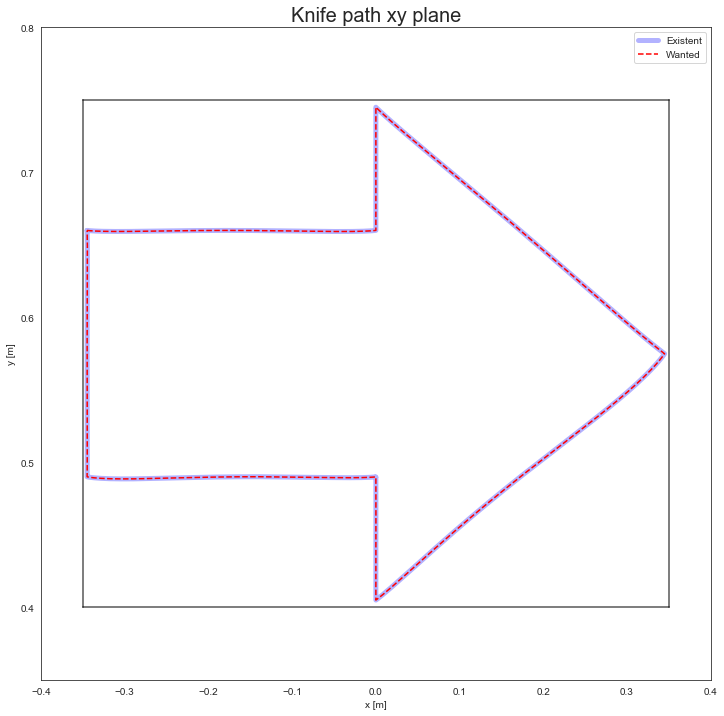

In [57]:
xy_plot(X1, X12)

### קו מקווקו - המסלול המתוכנן הרצוי, קו רציף - המסלול המתקבל.  ניתן לראות כי יש עקיבה אך התכנון של החץ אינו מדויק ב100 אחוז (למרות שהוא מאוד קרוב לצורה המקורית)

## $ \vec q $ existent vs wanted :
-------

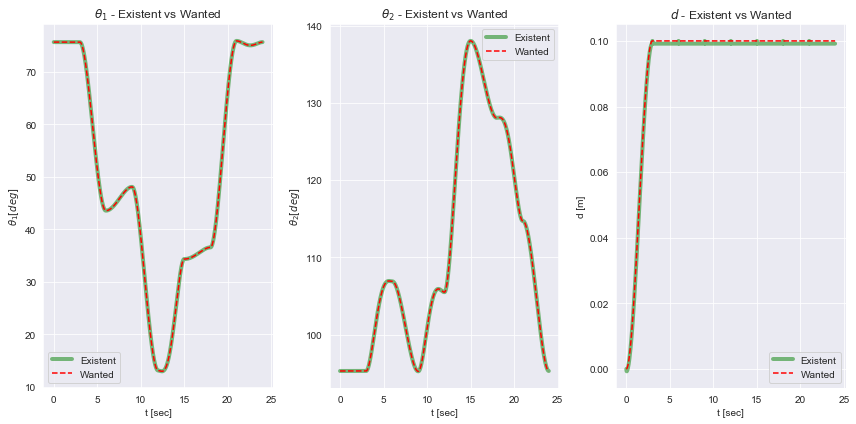

In [58]:
ex_vs_wa(Q1, Qd1)

## $ \dot {\vec q} $ existent vs wanted :
--------

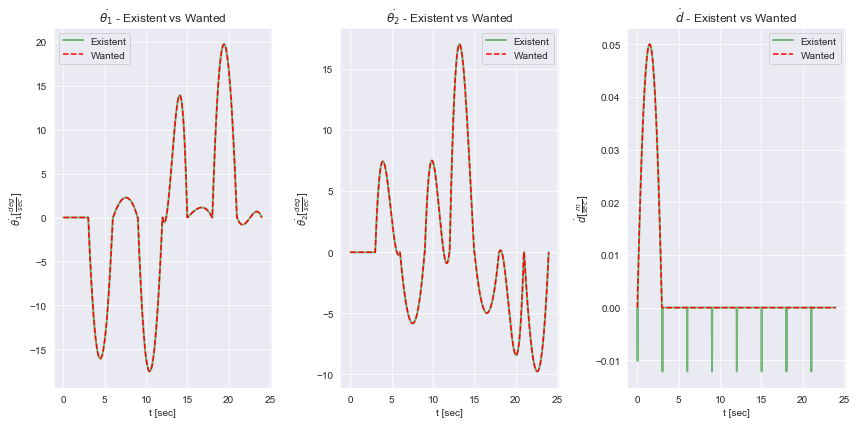

In [59]:
ex_vs_wa_vel(Q1, dQd1)

### גם כאן, הקו המקווקו מהווה רצוי אל מול הקו הרציף המהווה מצוי. נבחין כי עבור דרגות החופש הסיבוביות ישנה עקיבה טובה מאוד וכי עבור דרגת החופש הלינארית ישנה סטייה קטנה מאוד. ככל שנגדיל את פרק הזמן של כל מקטע, נקטיו את הקפיצות במהירות הלינארית. נציין כי קבוע הבקרה עבור הדרגה השלישית (הדרגה הלינארית) גדול מאוד, ולכן יקר מאוד דבר אשר מהווה חיסרון.


## $ (x, y, z) $ existent vs wanted :
--------

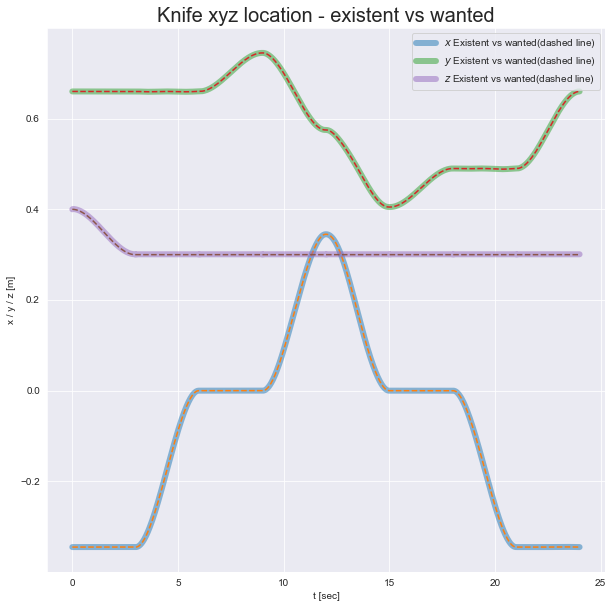

In [60]:
ex_vs_wa_xy(X1, X12)

## נבחין כי בסך הכל ישנה עקיבה טובה של המערכת אחרי המיקום הרצוי.

In [61]:
F_lst = [5., 10., 15.]
z_lst = []
for F in F_lst:
    Qi, Xi, Qdi, dQdi, X2i = ode_1(F, False)
    z_lst.append(Xi[:,2])    

## knife location - $ \hat Z$

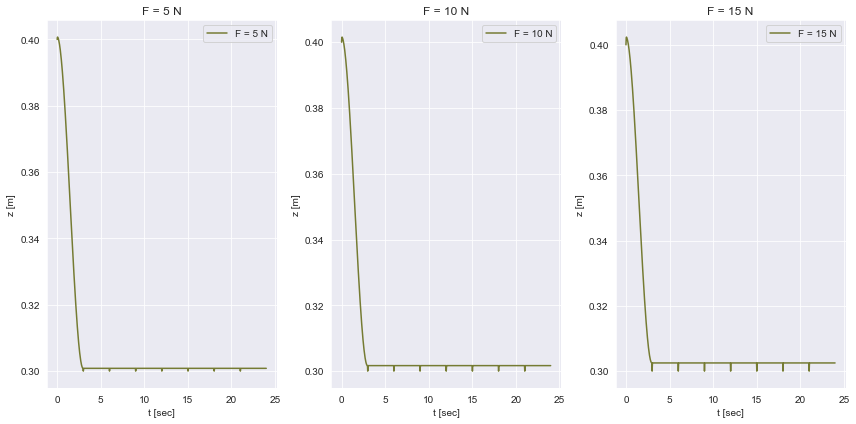

In [62]:
plot(z_lst, t_tot)

## נבחין כי ככל שהכוח גדל, כך גם השגיאות במיקום גדלות. ככל שנגדיל את קבוע הפרופורציה בבקר, כך נקטין את השגיאה. בפרט, בבחירת בקר מספיק גדול ושגיאה עבורה נאמר שהתוצאה מספיק מדוייקת בהפעלת כוח חיצוני של 15 ניוטון, נאמר כי קבועי הבקרה יכולים לשמש לכל טווח המדידות. 

# $ \tau $:
---

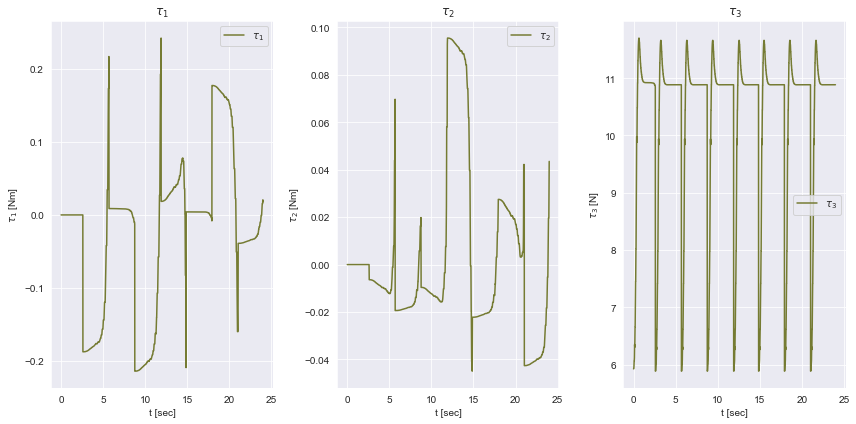

In [63]:
tau_graph(u_list1)

# Calculating path: Task Space:  
-----

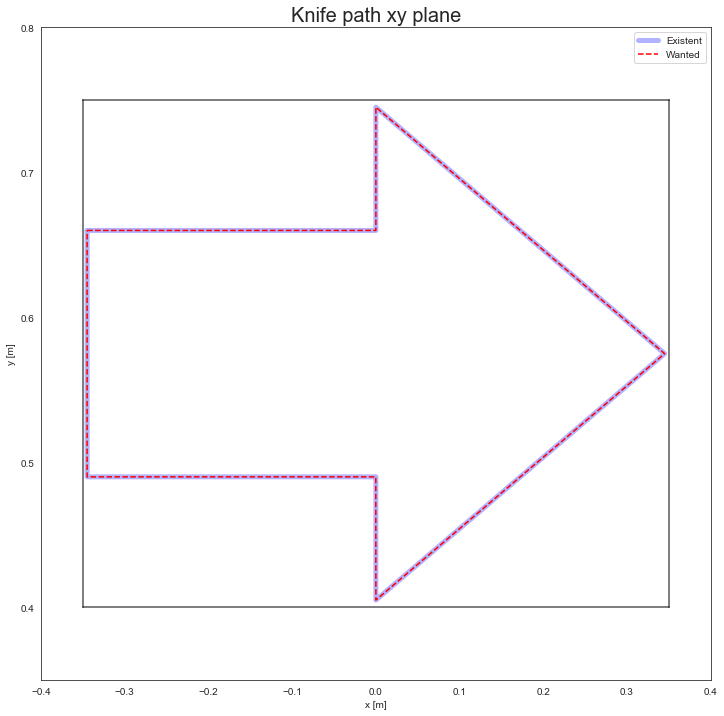

In [64]:
xy_plot(X2, X22)

## ניתן להבחין כי כעת המסלול מדוייק יותר מאשר המסלול הקודם!

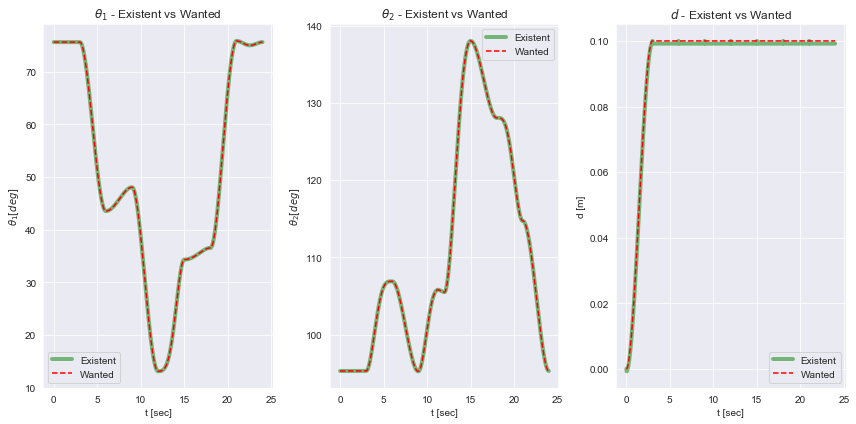

In [65]:
ex_vs_wa(Q2, Qd2)

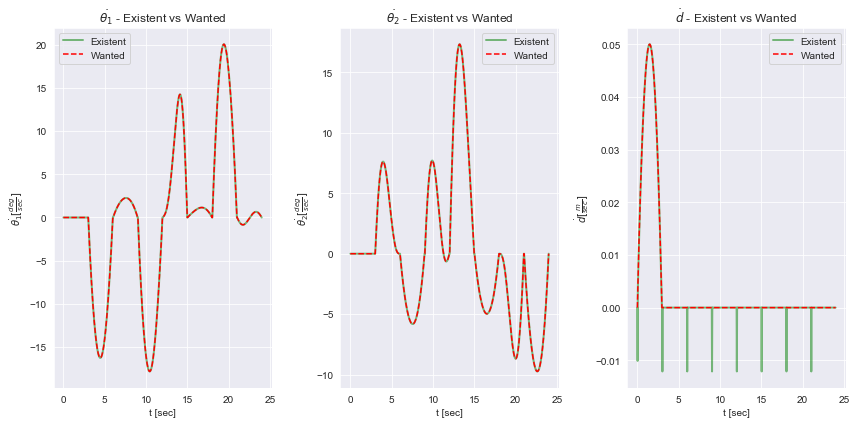

In [66]:
ex_vs_wa_vel(Q2, dQd2)

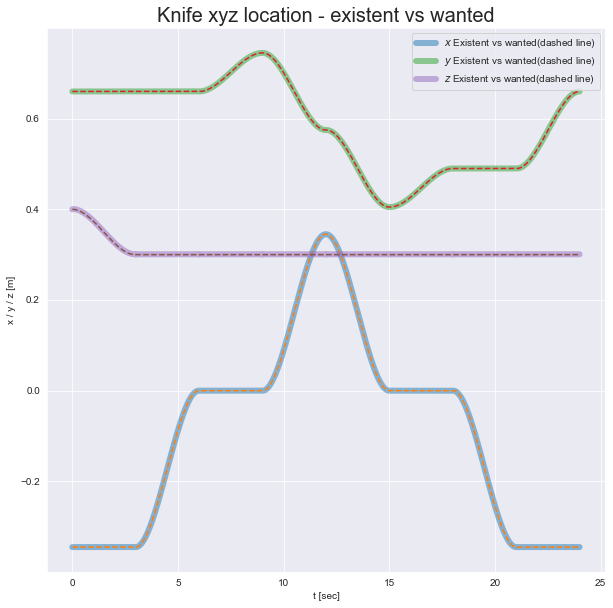

In [67]:
ex_vs_wa_xy(X2, X22)

In [68]:
z_lst = []
for F in F_lst:
    Qi, Xi, Qdi, dQdi, X2i = ode_2(F, False)
    z_lst.append(Xi[:,2])    

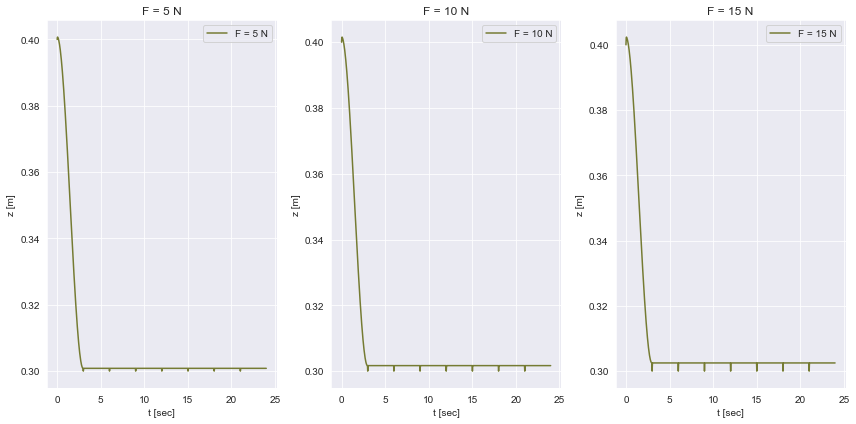

In [69]:
plot(z_lst, t_tot)

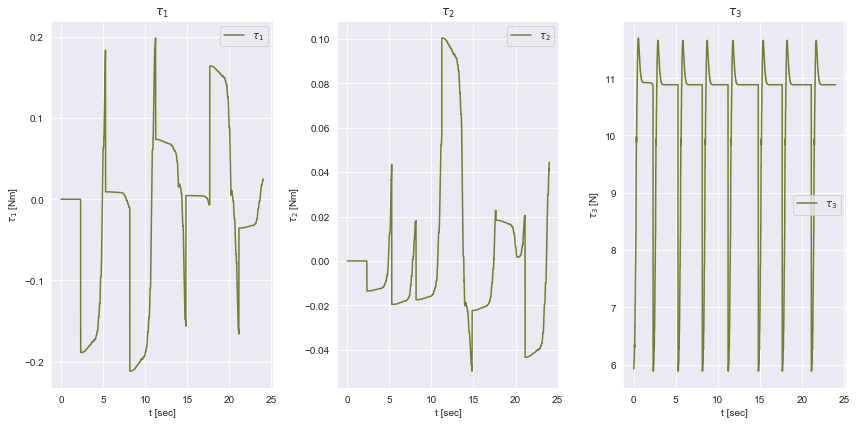

In [70]:
tau_graph(u_list2)